In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as sk
import scipy 
import igraph
import ts2vg # Time series to visibility graphs
import scipy.spatial.distance as distance
import scipy
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os 

# Classes e Funções

In [4]:
def geographical_distance(adj,pos):
    """
    Parameters:
    -----------
        adj - pares de pontos que correspondem a um ponto (série temporal) disposta no espaço geográfico da 
        bacia do rio Tamanduateí.
        pos - índice (i,j) de cada ponto na matriz que representa o espaço geográfico.
        
    Returns:
    --------
        A distância euclidiana entre os pontos distribuídos na região analisada.
    """
    geo_dist = {}
    for i in adj: # i é o par formado pelos grafos 'a' e 'b'
        a = pos[i[0]] # busca as coordenadas (i,j) do grafo 'a' no vetor que guarda a posição das séries na matriz
        b = pos[i[1]] # busca as coordenadas (i,j) do grafo 'b' no vetor que guarda a posição das séries na matriz
        dist = np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
        geo_dist[i] = dist
    return(geo_dist)

def norm(data):
    """
    Parameters:
    -----------
        Vetor numérico.
    
    Returns:
    --------
        Valores da vetor data entre o intervalo de 0 e 1.
    
    """
    n = []
    max_value = max(data)
    min_value = min(data)
    for i in range(len(data)):
        n.append((data[i]-min_value)/(max_value - min_value))
    return(n)

class reading():
    
    def files_and_validation():
        """
        Returns:
        --------
            Realiza a leitura dos arquivos contendo as matrizes de dados. Os dados inválidos das matrizes (-99) são
            removidos, gerando vetores com apenas os valores válidos.
            data ==> Vetor contendo apenas os valores válidos das matrizes
            pos ==> Vetor contendo a posição que os valores válidos ocupam na matriz de dados original
        """
        files_list = os.listdir('data-01-original');
        files_list.sort();
        data = [];
        for i in range(len(files_list)):
            m = np.genfromtxt('data-01-original/'+str(files_list[i]));
            validated = [];
            pos = [];
            for row in range(len(m[:,0])):
                for column in range(len(m[0,:])):
                    if (m[row][column] != -99):
                        validated.append(m[row,column]);
                        pos.append([row,column]);
            data.append(validated);
                    
        return(data,pos);

    def timeSeriesGeneration(validated_data):
        """
        Parameters:
        -----------
            Arrays unidimensionais contendo os valores estimados das previsões
        Returns:
        --------
            Série temporal associada a cada ponto válido (diferente de -99).
            A série temporal 0 será composta por todos os valores na posição 0 dos 4464 arrays, e assim
            em diante. O resultado são 587 séries temporais de tamanho 4464.
        """
        time_series = {};
        for i in range(len(validated_data[0])):
            s = np.empty((0,0));
            for j in range(len(validated_data)):
                s = np.append(s,validated_data[j][i]);
            time_series[i] = s;
        
        for t in range(len(time_series)):
            for k in range(len(time_series[0])):
                if (time_series[t][k] < 20):
                    time_series[t][k] = 0;
                
        return(time_series);

class network():

    def graphs(data):
        """
        Parameters:
        -----------
            Lista de valores inteiros que correspondem aos nós de uma rede. Os valores devem ser conectados
            em sequência.
            Exemplo:
                data = (1,2,8,4,5,2,7,9,4)
                adjacency_list from data: (1,2),(2,8),(8,4),(4,5),(5,2),(2,7),(7,9),(9,4)
            Assim, um grafo seria construído usando o conjunto data como os nós da rede e o conjunto
            adjacency_list seria responsável pela conexão dos nós.
            Os pares repetidos na lista de adjacência irão contabilizar os pesos. Se um par de conexão se
            repete 5 vezes, por exemplo, então o peso desse link é 5.
        
        Returns:
        --------
            1. all_metrics - Dicionário contendo as medidas average degree, average betweenness,
            average closeness, density e diameter.
            2. seq_metrics - Dicionário contendo 587 índices (587 grafos). Cada índice possui outro dicionário
            com as sequências de valores de degree, betweenness e closeness.
            3. global_metrics - Dicionário contendo as métricas assortativity degree, heterogeinity parameter,
            density e diameter para todos os grafos.
            4. local_metrics - Dicionário contendo as médias de betweenness, degree e closeness.
        """

        # Graph creation from decimal integer array

        graph = igraph.Graph()

        #graph.add_vertices(max(data)+1)
        graph.add_vertices(len(data))

        #adjacency_list = np.empty((0,0), int)
        aux_list = []
        adjacency_list = []
        weights = []
        edge_weight = {}

        for i in range(len(data)):
            if not(len(data)-1 == i):
                aux_list.append([data[i],data[i+1]])
        
        # sorting
        for i in range(len(aux_list)):
            aux_list[i].sort()
        
        # Counting repetitions
        for i in range(len(aux_list)):
            weights.append(aux_list.count(aux_list[i]))
        
        # keys: pair of edges
        # value: weights
        for i in range(len(aux_list)):
            edge_weight[aux_list[i][0],aux_list[i][1]] = weights[i]
        
        for i in range(len(data)):
            graph.vs[i]["label"] = i

        graph.add_edges(list(edge_weight.keys())) # Full graph, with disconnected nodes
        
        graph.es['weight'] = list(edge_weight.values()) # Weight list based on how many times a pair of edges occurs

        # Only nodes with degree > 0

        disconnected = np.empty((0,0), int)
        for i in range(graph.vcount()):
            if (graph.vs[i].degree() == 0):
                disconnected = np.append(disconnected, i)

        graph.delete_vertices(disconnected)
        
        all_metrics, seq_metrics, global_metrics, local_metrics = network.metrics(graph)
        
        return(all_metrics, seq_metrics, global_metrics, local_metrics)
        
    def metrics(g):
        """
        Parameters:
        -----------
            Grafo criado na biblioteca igraph
            
        Returns:
        --------
            1. feature_dict - Dicionário contendo as medidas average degree, average betweenness,
            average closeness, density e diameter.
            2. seq_dict - Dicionário contendo 587 índices (587 grafos). Cada índice possui outro dicionário
            com as sequências de valores de degree, betweenness e closeness.
            3. feature_global_dict - Dicionário contendo as métricas assortativity degree, heterogeinity parameter,
            density e diameter para todos os grafos.
            4. feature_local_dict - Dicionário contendo as médias de betweenness, degree e closeness.           
        """
        
        ## Unweighted metrics ## 
        
        def heterogeinity(degree):
            power_degree = [] # degree sequence 
            for i in degree:
                power_degree.append(i**2)
                hp = ( (sum(power_degree)/len(power_degree))/((sum(degree)/len(degree))**2) )
            return(hp)
        
        # Degree and Average Degree
        degree_sequence = [round(i,4) for i in g.degree()]
        avg_degree = round((sum(degree_sequence)/len(degree_sequence)),4)

        # Diameter
        diameter = round(g.diameter(),4)

        # Betweenness and Average Betweenness
        betweenness_sequence = [round(i,4) for i in g.betweenness()]
        avg_betweenness = round((sum(betweenness_sequence)/len(betweenness_sequence)),4)

        # Closeness and Average Closeness
        closeness_sequence = [round(i,4) for i in g.closeness()]
        avg_closeness = round(sum(closeness_sequence)/len(closeness_sequence),4)

        # Density
        density = round(g.density(),4)
        
        # Heterogeinity parameter
        hp = round(heterogeinity(g.degree()),4)
        
        ## Weighted metrics ##   --> Not implemented yet
        
        feature_dict = {
            'Avg_Betweenness': avg_betweenness,
            'Avg_Closeness': avg_closeness,
            'Avg_Degree': avg_degree,
            'Diameter': diameter,
            'Density': density
        }
        
        seq_dict = {
            'Betweenness': betweenness_sequence,
            'Closeness': closeness_sequence,
            'Degree': degree_sequence,
        }
        
        feature_global_dict = {
            'heterogeneity_Parameter': hp,
            'Density': density,
            'Diameter': diameter
        }
    
        feature_local_dict = {
            'Avg_Betweenness': avg_betweenness,
            'Avg_Closeness': avg_closeness,
            'Avg_Degree': avg_degree
        }
        
        return(feature_dict,seq_dict,feature_global_dict,feature_local_dict)

class algorithms():
    
    def DCSD(time_series,n): # Dynamical Characterization with Symbolic Dynamics - DCSD
        '''
        Parameters:
        -----------
            time_series - Série temporal a ser convertida em grafo.
            n - tamanho da palavra binária usada na conversão binário/decimal
            
            Exemplo de aplicação do algoritmo:
                1. Definir o valor máximo e mínimo de uma série temporal:
                    1.1. x = [5,8,9,12,10,7,4,3,5,7,11]
                    1.2. Max: 12
                         Min: 3
                2. Definir o centro da série temporal:
                    2.1. centro: (12+3)/2 = 7.5
                3. Gerar um array binário (b), tal como se segue:
                    3.1. x(i) >= centro, então b(i) = 1
                    3.2. x(i) < centro, então b(i) = 0
                    3.3. b = [0,1,1,1,1,0,0,0,0,0,1]
                4. Conversão da série binária em uma série decimal:
                    4.1. A conversão será feita através de palavras binárias de tamanho N.
                    4.2. O grupamento de tamanho 4 terá um comportamento deslizante, sempre com um passo
                    à direita:
                        4.2.1. Assumindo N = 4:
                                [|0,1,1,1|,1,0,0,0,0,0,1]
                                     7
                                [0,|1,1,1,1|,0,0,0,0,0,1]
                                       15
                                [0,1,|1,1,1,0|,0,0,0,0,1]
                                         14
                                [0,1,1,|1,1,0,0|,0,0,0,1]
                                          12
                                [0,1,1,1,|1,0,0,0|,0,0,1]
                                             8
                                [0,1,1,1,1,|0,0,0,0|,0,1]
                                               0
                                [0,1,1,1,1,0,|0,0,0,0|,1]
                                                 0
                                [0,1,1,1,1,0,0,|0,0,0,1|]
                                                   1

                                Nova série decimal inteira = [7,15,14,12,8,0,0,1]

                5. Cada valor da nova série gerada corresponde a um nó e a conexão entre esses nós se dá
                através da sequência dos valores, como se segue: (7,15), (15,14), (14,12), e assim por diante.
            
            Returns:
            --------
                graph_metrics - Dicionário normalizado contendo as medidas average degree, average betweenness,
                average closeness, density e diameter.
                graph_degree - Array contendo o degree de cada nó da rede.
                graph_betweenness - Array contendo o betweenness de cada nó da rede.
                graph_closeness - Array contendo o closeness de cada nó da rede.

            References:
            -----------
                FREITAS, Vander LS; LACERDA, Juliana C.; MACAU, Elbert EN.
                Complex Networks Approach for Dynamical Characterization of Nonlinear Systems.
                International Journal of Bifurcation and Chaos, v. 29, n. 13, p. 1950188, 2019.
            '''
        center = (max(time_series)+min(time_series))/2

        # Converting time_series to binary

        binary_array = np.empty((0,0), int)

        for i in time_series:
            if i >= center:
                binary_array = np.append(binary_array,1)
            else:
                binary_array = np.append(binary_array,0)

        # Converting the binary array to decimal (integer)

        decimal_array = np.empty((0,0), int)

        for i in range(len(binary_array)-n+1): 
            word = binary_array[i:i+n]
            string_word = ''
            for j in range(len(word)): 
                string_word = string_word + str(word[j])
            # Converting to decimal
            decimal_number = int(string_word,2)
            decimal_array = np.append(decimal_array,decimal_number)     

        all_metrics_DCSD, seq_metrics_DCSD, global_metrics_DCSD, local_metrics_DCSD = network.graphs(decimal_array)

        return(all_metrics_DCSD, seq_metrics_DCSD, global_metrics_DCSD, local_metrics_DCSD)

    def DCTIF(time_series, n): # Dynamical Characterization using the Top Integral Function - DCTIF
        """
        Parameters:
        -----------
            time_series - Série temporal a ser convertida em grafo.
            n - Tamanho do intervalo em que os dados serão mapeados.            
            Exemplo:
                1. A função DCTIF é definida como: Yk = [N · xk ] = min{i ∈ Z | N · xk ≤ i}
                    1.1. Exemplo: x = [0.467, 1.0, 0.933, 0.8, 0.533, 0.0, 0.0, 0.067, 0.0]
                    1.2. Usando N = 5
                    1.3. Yk[0] = min{i ∈ Z | 5 · 0.467 ≤ i} = min{i ∈ Z | 2.335 ≤ i} = 3
                    1.4. Yk = [3,5,5,4,3,1,1,1,1]
                    1.5. Cada valor da nova série gerada corresponde a um nó e a conexão entre eles se dá
                    através da sequência dos valores, como se segue: (3,5), (5,5), (5,4), e assim em diante.
            
        Returns:
        --------
            graph_metrics - Dicionário normalizado contendo as medidas average degree, average betweenness,
            average closeness, density e diameter.
            graph_degree - Array contendo o degree de cada nó da rede.
            graph_betweenness - Array contendo o betweenness de cada nó da rede.
            graph_closeness - Array contendo o closeness de cada nó da rede. 
            
        References:
        -----------
            FREITAS, Vander LS; LACERDA, Juliana C.; MACAU, Elbert EN.
            Complex Networks Approach for Dynamical Characterization of Nonlinear Systems.
            International Journal of Bifurcation and Chaos, v. 29, n. 13, p. 1950188, 2019.
        """
        # Normalizing the data
        time_series_normalized = np.empty((0,0), float)
        min_value = min(time_series)
        max_value = max(time_series)
        for i in time_series:
            time_series_normalized = np.append(time_series_normalized, ((i-min_value)/(max_value-min_value)))    

        nodes_array = np.empty((0,0),int)
        for i in time_series_normalized:
            if (i*n == 0):
                nodes_array = np.append(nodes_array,int(1))
            elif (round(i*n) - i*n >= 0.0):
                nodes_array = np.append(nodes_array,int(round(i*n)))
            else:
                nodes_array = np.append(nodes_array,int(round(i*n) + 1.0))

        all_metrics_DCTIF, seq_metrics_DCTIF, global_metrics_DCTIF, local_metrics_DCTIF = network.graphs(nodes_array)

        return(all_metrics_DCTIF, seq_metrics_DCTIF, global_metrics_DCTIF, local_metrics_DCTIF)

    def VG(time_series):
        """
        Parameters:
        -----------
            Uma série temporal que será transformada em um grafo do tipo natural visibility graph. Cada ponto
            da série será convertido em um nó, sendo que a conexão entre os nós é definida de acordo com um 
            critério de visibilidade.
            Exemplo:
                Critério de visibilidade: yc < yb + (ya - yb)*((tb - tc)/(tb - ta))
                    Dois pontos quaisquer em uma série temporal, (ya,ta) e (yb,tb), serão conectados no grafo,
                    se, e somente se, um terceiro ponto, (yc,tc), colocado entre eles for capaz de satisfazer
                    o critério de visibilidade.
                y = [5,8,9,12,10,7,4,3,5,7,11]
                t = [0,1,2,3,4,5,6,7,8,9,10] -> eixo temporal 
                Avaliando os pontos ya = 5 e yb = 8:
                - Não há pontos intermediários, yc = 0
                - Critério:
                    0 < 8 + (5-8)*((1-0)/(1-0))
                    0 < 8 + (-3)*1 
                    0 < 5
                    Logo, os pontos 5 e 8 serão conectados.
                Avaliando os pontos ya = 9 e yb = 10:
                - Ponto intermediário: yc = 12
                - Critério:
                    12 < 10 + (9 - 10)*((4-3)/(4-2))
                    12 < 10 + (-1)*(1/2)
                    12 < 10 - 1/2
                    12 < 9.5
                    Condição não satisfeita. Sendo assim, os pontos 9 e 10 não seriam conectados na rede.
                
        Returns:
        --------
            graph_metrics - Dicionário normalizado contendo as medidas average degree, average betweenness,
            average closeness, density e diameter.
            graph_degree - Array contendo o degree de cada nó da rede.
            graph_betweenness - Array contendo o betweenness de cada nó da rede.
            graph_closeness - Array contendo o closeness de cada nó da rede.

        References:
        -----------
            LACASA, Lucas et al. 
            From time series to complex networks: The visibility graph.
            Proceedings of the National Academy of Sciences, v. 105, n. 13, p. 4972-4975, 2008.
        """
        vg_igraph = ts2vg.NaturalVisibilityGraph(time_series).as_igraph()
        
        all_metrics_VG, seq_metrics_VG, global_metrics_VG, local_metrics_VG = network.metrics(vg_igraph)
        
        return(all_metrics_VG, seq_metrics_VG, global_metrics_VG, local_metrics_VG)

class saving():
    
    def saving_metrics(all_metrics_DCSD,all_metrics_DCTIF,all_metrics_VG):
        """
        Parameters:
        -----------
            Recebe dicionários contendo métricas de todos os grafos para cada algoritmo. Cada dicionário contém 
            chaves que vão de 0 até 586, representando os 587 grafos. Os valores de cada chaves são dicionários
            contendo as métricas average degree, average betweenness, average closeness, density e diameter.
            Os dicionários são convertidos em DataFrames Pandas e depois são salvos no formato .csv.
        """
        dcsd_df = pd.DataFrame(data=all_metrics_DCSD)
        dctif_df = pd.DataFrame(data=all_metrics_DCTIF)
        vg_df = pd.DataFrame(data=all_metrics_VG)

        dcsd_df.T.to_csv('metrics-using-original-data/DCSD/DCSD-metrics.csv',index=False)
        dctif_df.T.to_csv('metrics-using-original-data/DCTIF/DCTIF-metrics.csv',index=False)
        vg_df.T.to_csv('metrics-using-original-data/VG/VG-metrics.csv',index=False)
   
    
    def saving_sequences(seq_metrics_DCSD,seq_metrics_DCTIF,seq_metrics_VG):
        """
        Parameters:
        -----------
            Recebe dicioinários com as sequências de métricas para todos os grafos.
            Cada índice do dicionário (corresponde a um grafo) possui um outro dicionário contendo as
            sequências de degree, betweenness e closeness para aquele grafo. 
            Essas métricas serão separadas e cada uma será salva em um arquivo .csv contendo a sequência de 
            dada métrica para os 587 grafos.
        """
        
        def check_length(data):
            """
            Parameters:
            -----------
                Sequência de valores correspondentes a uma dada métrica.
                Os grafos gerados pelos algoritmos DCSD e DCTIF possuem tamanhos diferentes, o que gera 
                sequências de tamanhos diferentes. A função irá padronizar esse comprimento adicionando 0 ao 
                final das sequências.
            Returns:
            --------
                Uma sequência de métricas com tamanho padrão de 4464. No caso das métricas geradas pelo 
                visibility graph, nada será feito.
            """
            if (len(data) != 4464):
                for i in range(4464-len(data)):
                    data.append(0)
            return(data)

        btw_DCSD = {}
        clo_DCSD = {}
        deg_DCSD = {}
        btw_DCTIF = {}
        clo_DCTIF = {}
        deg_DCTIF = {}
        btw_VG = {}
        clo_VG = {}
        deg_VG = {}
        for i in range(len(seq_metrics_DCSD)):
            btw_DCSD[i] = check_length(seq_metrics_DCSD[i]['Betweenness'])
            clo_DCSD[i] = check_length(seq_metrics_DCSD[i]['Closeness'])
            deg_DCSD[i] = check_length(seq_metrics_DCSD[i]['Degree'])
            btw_DCTIF[i] = check_length(seq_metrics_DCTIF[i]['Betweenness'])
            clo_DCTIF[i] = check_length(seq_metrics_DCTIF[i]['Closeness'])
            deg_DCTIF[i] = check_length(seq_metrics_DCTIF[i]['Degree'])
            btw_VG[i] = check_length(seq_metrics_VG[i]['Betweenness'])
            clo_VG[i] = check_length(seq_metrics_VG[i]['Closeness'])
            deg_VG[i] = check_length(seq_metrics_VG[i]['Degree'])

        #DCSD
        btw_DCSD_df = pd.DataFrame(data=btw_DCSD)
        clo_DCSD_df = pd.DataFrame(data=clo_DCSD)
        deg_DCSD_df = pd.DataFrame(data=deg_DCSD)

        btw_DCSD_df.to_csv('metrics-using-original-data/DCSD/DCSD-betweenness.csv',index=False)
        clo_DCSD_df.to_csv('metrics-using-original-data/DCSD/DCSD-closeness.csv',index=False)
        deg_DCSD_df.to_csv('metrics-using-original-data/DCSD/DCSD-degree.csv',index=False)

        #DCTIF
        btw_DCTIF_df = pd.DataFrame(data=btw_DCTIF)
        clo_DCTIF_df = pd.DataFrame(data=clo_DCTIF)
        deg_DCTIF_df = pd.DataFrame(data=deg_DCTIF)

        btw_DCTIF_df.to_csv('metrics-using-original-data/DCTIF/DCTIF-betweenness.csv',index=False)
        clo_DCTIF_df.to_csv('metrics-using-original-data/DCTIF/DCTIF-closeness.csv',index=False)
        deg_DCTIF_df.to_csv('metrics-using-original-data/DCTIF/DCTIF-degree.csv',index=False)    

        #VG
        btw_VG_df = pd.DataFrame(data=btw_VG)
        clo_VG_df = pd.DataFrame(data=clo_VG)
        deg_VG_df = pd.DataFrame(data=deg_VG)

        btw_VG_df.to_csv('metrics-using-original-data/VG/VG-betweenness.csv',index=False)
        clo_VG_df.to_csv('metrics-using-original-data/VG/VG-closeness.csv',index=False)
        deg_VG_df.to_csv('metrics-using-original-data/VG/VG-degree.csv',index=False) 
    
    def saving_global_metrics(global_metrics_DCSD,global_metrics_DCTIF,global_metrics_VG):
        """
        Parameters:
        -----------
            Recebe os dicionários de métricas globais e os salva no formato .csv.
        """
        global_metrics_DCSD_df = pd.DataFrame(data=global_metrics_DCSD)
        global_metrics_DCTIF_df = pd.DataFrame(data=global_metrics_DCTIF)
        global_metrics_VG_df = pd.DataFrame(data=global_metrics_VG)

        global_metrics_DCSD_df.T.to_csv('metrics-using-original-data/DCSD/DCSD-global-metrics.csv',index=False)
        global_metrics_DCTIF_df.T.to_csv('metrics-using-original-data/DCTIF/DCTIF-global-metrics.csv',index=False)
        global_metrics_VG_df.T.to_csv('metrics-using-original-data/VG/VG-global-metrics.csv',index=False)

    def saving_local_metrics(local_metrics_DCSD,local_metrics_DCTIF,local_metrics_VG):
        """
        Parameters:
        -----------
            Recebe os dicionários de métricas locais e os salva no formato .csv.
        """
        local_metrics_DCSD_df = pd.DataFrame(data=local_metrics_DCSD)
        local_metrics_DCTIF_df = pd.DataFrame(data=local_metrics_DCTIF)
        local_metrics_VG_df = pd.DataFrame(data=local_metrics_VG)

        local_metrics_DCSD_df.T.to_csv('metrics-using-original-data/DCSD/DCSD-local-metrics.csv',index=False)
        local_metrics_DCTIF_df.T.to_csv('metrics-using-original-data/DCTIF/DCTIF-local-metrics.csv',index=False)
        local_metrics_VG_df.T.to_csv('metrics-using-original-data/VG/VG-local-metrics.csv',index=False)
    
        
class comparing():
    
    def __init__(self, graph_metrics):
        """
        Parameters:
        -----------
            Array de métricas que será usado como parâmetro para o restante das funções dessa classe.
            São recebidos tanto os feature arrays, com métricas combinadas, quanto os sequence arrays, como é
            o caso da sequência de graus.
            As métricas enviadas são as pertencentes a todos os grafos. Sendo assim, self.metrics_array
            receberá um array de tamanho 587, onde cada posição terá um array de métricas correspondente a
            um grafo.
            As funções de distância/similaridade irão computar a medida entre todos os pares (a,b) de métricas,
            com a e b variando de 0 até 586, apenas desconsiderando casos como: 
                - a = b
                - (b,a) se já existir um valor calculado para o par (a,b)
        """
        self.metrics_array = graph_metrics
    
    def jensenshannon(self):
        """
        Returns:
        --------
            Retorna a o valor da distância de Jensen-Shannon, no formato de um dicionário, entre todos os 
            pares de grafos.
            A função computa a raiz quadrada da divergência de Jensen-Shannon:
                JSD(P||Q) = ((D(P||M) + D(Q||M))/2)^(1/2)
                Onde:
                    D é a divergência de Kullback-Leibler 
                    M = (P + Q)/2 
        
        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2205.
                
        """
        jensenshannon_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                jensenshannon_dist[i,j] = distance.jensenshannon(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(jensenshannon_dist)    
    
    
    def euclidean(self):
        """
        Returns:
        --------
            Retorna a o valor da distância Euclidiana, no formato de um dicionário, entre todos os 
            pares de grafos.
            Considerando os vetores, a e b, a distância euclidiana é calculada como:
                e_dist(a,b) = ||a - b||
        
        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2204-2205.
            
        """
        euclidean_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                euclidean_dist[i,j] = distance.euclidean(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(euclidean_dist)

    def manhattan(self):
        """    
        Returns:
        --------
            Retorna a o valor da distância de Manhattan (Cityblock), no formato de um dicionário, entre 
            todos os pares de grafos.
            Considerando os vetores a e b, a distância de manhattan é calculada como:
                m_dist(a,b) = Σ(|ai - bi|)
                i deve ser iterado a fim de percorrer todos os elementos de cada vetor.

        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2203.
        """
        manhattan_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                manhattan_dist[i,j] = distance.cityblock(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(manhattan_dist)

    def canberra(self):
        """   
        Returns:
        --------
            Retorna a o valor da distância de Canberra, no formato de um dicionário, entre 
            todos os pares de grafos.
            Considerando os vetores a e b, a distância de canberra é calculada como:
                c_dist(a,b) = Σ((|ai - bi|)/(|ai|+|bi|))
                i deve ser iterado a fim de percorrer todos os elementos de cada vetor

        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2202.
        """
        canberra_dist = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                canberra_dist[i,j] = distance.canberra(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(canberra_dist)

    def cosine(self):
        """    
        Returns:
        --------
            Retorna a o valor da distância baseada em cosseno, no formato de um dicionário, entre 
            todos os pares de grafos.
            Considerando os vetores a e b, o cosseno entre esses dois vetores pode ser obtido pela
            seguinte relação:
                cos(θ) = (a·b)/(||a||*||b||)
                cos_dist = 1 - cos(θ)

                (a·b) é o produto escalar entre os dois vetores.
                
        Reference:
        ----------
            SciPy community. SciPy Reference Guide. <https://docs.scipy.org/doc/scipy/scipy-ref-1.5.4.pdf>, 
            v. 1.5.4, p. 2204.
        """
        cosine_sim = {}
        ctrl = 1
        for i in range(len(self.metrics_array)):
            for j in range(ctrl,len(self.metrics_array)):
                cosine_sim[i,j] = distance.cosine(self.metrics_array[i],self.metrics_array[j])
            ctrl += 1
        return(cosine_sim)
# -------------------------------------------------------------------------------------------------------------    

# Leitura dos arquivos e geração das séries temporais

In [5]:
# Estimated execution time: 24s
init = time.time()

# Time series
validated_files,position = reading.files_and_validation() # removing -99 values and saving the position of the valid points in a dictionary
meteorological_time_series = reading.timeSeriesGeneration(validated_files)

end = time.time()
print(end-init)

25.97377347946167


# Criação dos grafos

In [10]:
# Estimated execution time: 2797s
init = time.time()

all_metrics_VG = {}
seq_metrics_VG = {}
global_metrics_VG = {}
local_metrics_VG = {}

all_metrics_DCSD = {}
seq_metrics_DCSD = {}
global_metrics_DCSD = {}
local_metrics_DCSD = {}

all_metrics_DCTIF = {}
seq_metrics_DCTIF = {}
global_metrics_DCTIF = {}
local_metrics_DCTIF = {}

for idx in range(len(meteorological_time_series)):
    print(idx,"de",(len(meteorological_time_series)-1))
    all_metrics_VG[idx], seq_metrics_VG[idx], global_metrics_VG[idx], local_metrics_VG[idx] = algorithms.VG(meteorological_time_series[idx])
    all_metrics_DCSD[idx], seq_metrics_DCSD[idx], global_metrics_DCSD[idx], local_metrics_DCSD[idx] = algorithms.DCSD(meteorological_time_series[idx],10)
    all_metrics_DCTIF[idx], seq_metrics_DCTIF[idx], global_metrics_DCTIF[idx], local_metrics_DCTIF[idx] = algorithms.DCTIF(meteorological_time_series[idx],50)
    
end = time.time()
print(end-init)

0 de 586
1 de 586
2 de 586
3 de 586
4 de 586
5 de 586
6 de 586
7 de 586
8 de 586
9 de 586
10 de 586
11 de 586
12 de 586
13 de 586
14 de 586
15 de 586
16 de 586
17 de 586
18 de 586
19 de 586
20 de 586
21 de 586
22 de 586
23 de 586
24 de 586
25 de 586
26 de 586
27 de 586
28 de 586
29 de 586
30 de 586
31 de 586
32 de 586
33 de 586
34 de 586
35 de 586
36 de 586
37 de 586
38 de 586
39 de 586
40 de 586
41 de 586
42 de 586
43 de 586
44 de 586
45 de 586
46 de 586
47 de 586
48 de 586
49 de 586
50 de 586
51 de 586
52 de 586
53 de 586
54 de 586
55 de 586
56 de 586
57 de 586
58 de 586
59 de 586
60 de 586
61 de 586
62 de 586
63 de 586
64 de 586
65 de 586
66 de 586
67 de 586
68 de 586
69 de 586
70 de 586
71 de 586
72 de 586
73 de 586
74 de 586
75 de 586
76 de 586
77 de 586
78 de 586
79 de 586
80 de 586
81 de 586
82 de 586
83 de 586
84 de 586
85 de 586
86 de 586
87 de 586
88 de 586
89 de 586
90 de 586
91 de 586
92 de 586
93 de 586
94 de 586
95 de 586
96 de 586
97 de 586
98 de 586
99 de 586
100 de 586

# Salvamento das métricas

In [11]:
# Estimated excecution time: 13s
init = time.time()

saving.saving_metrics(all_metrics_DCSD,all_metrics_DCTIF,all_metrics_VG)
saving.saving_sequences(seq_metrics_DCSD,seq_metrics_DCTIF,seq_metrics_VG)
saving.saving_global_metrics(global_metrics_DCSD,global_metrics_DCTIF,global_metrics_VG)
saving.saving_local_metrics(local_metrics_DCSD,local_metrics_DCTIF,local_metrics_VG)

end = time.time()
print(end-init)

13.457370519638062


# Cálclulo das distâncias 

## Visibility Graphs - VG

In [6]:
# VG
# Tempo de execução: 267s
init = time.time()

vg_metrics_df = pd.read_csv("metrics-using-modified-data/VG/VG-metrics.csv") # Cada linha do DataFrame é um vetor de características
vg_global_metrics_df = pd.read_csv("metrics-using-modified-data/VG/VG-global-metrics.csv") # Cada linha do DataFrame é um vetor de características
vg_local_metrics_df = pd.read_csv("metrics-using-modified-data/VG/VG-local-metrics.csv") # Cada linha do DataFrame é um vetor de características
vg_degrees_df = pd.read_csv("metrics-using-modified-data/VG/VG-degree.csv") # Cada coluna representa a distribuição de graus de uma rede
vg_betweenness_df = pd.read_csv("metrics-using-modified-data/VG/VG-betweenness.csv") # Cada coluna representa a distribuição de betweenness de uma rede
vg_closeness_df = pd.read_csv("metrics-using-modified-data/VG/VG-closeness.csv") # Cada coluna representa a distribuição de closeness de uma rede

vg_global_metrics_array = vg_global_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
vg_local_metrics_array = vg_local_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
vg_metrics_array = vg_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
vg_degrees_array = vg_degrees_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de graus
vg_betweenness_array = vg_betweenness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de betweenness
vg_closeness_array = vg_closeness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de closeness

# Calculando as métricas entre todos os vetores de características.

dist_vg_metrics = comparing(vg_metrics_array)


euclidean_dist_vg_metrics = dist_vg_metrics.euclidean() 
manhattan_dist_vg_metrics = dist_vg_metrics.manhattan() 
canberra_dist_vg_metrics = dist_vg_metrics.canberra() 
cosine_dist_vg_metrics = dist_vg_metrics.cosine() 
jensenshannon_dist_vg_metrics = dist_vg_metrics.jensenshannon() 

# Calculando as métricas entre todos os vetores de características globais.

dist_vg_global_metrics = comparing(vg_global_metrics_array)


euclidean_dist_vg_global_metrics = dist_vg_global_metrics.euclidean() 
manhattan_dist_vg_global_metrics = dist_vg_global_metrics.manhattan() 
canberra_dist_vg_global_metrics = dist_vg_global_metrics.canberra() 
cosine_dist_vg_global_metrics = dist_vg_global_metrics.cosine() 
jensenshannon_dist_vg_global_metrics = dist_vg_global_metrics.jensenshannon() 

# Calculando as métricas entre todos os vetores de características locais.

dist_vg_local_metrics = comparing(vg_local_metrics_array)


euclidean_dist_vg_local_metrics = dist_vg_local_metrics.euclidean() 
manhattan_dist_vg_local_metrics = dist_vg_local_metrics.manhattan() 
canberra_dist_vg_local_metrics = dist_vg_local_metrics.canberra() 
cosine_dist_vg_local_metrics = dist_vg_local_metrics.cosine() 
jensenshannon_dist_vg_local_metrics = dist_vg_local_metrics.jensenshannon() 

# Calculando as métricas entre todos os vetores com distribuição de graus.

dist_vg_degrees = comparing(vg_degrees_array)

euclidean_dist_vg_degrees = dist_vg_degrees.euclidean() 
manhattan_dist_vg_degrees = dist_vg_degrees.manhattan() 
canberra_dist_vg_degrees = dist_vg_degrees.canberra() 
cosine_dist_vg_degrees = dist_vg_degrees.cosine() 
jensenshannon_dist_vg_degrees = dist_vg_degrees.jensenshannon() 

# Calculando as métricas entre todos os vetores com a sequência de betweenness.

dist_vg_betweenness = comparing(vg_betweenness_array)

euclidean_dist_vg_betweenness = dist_vg_betweenness.euclidean() 
manhattan_dist_vg_betweenness = dist_vg_betweenness.manhattan()  
canberra_dist_vg_betweenness = dist_vg_betweenness.canberra()  
cosine_dist_vg_betweenness = dist_vg_betweenness.cosine()  
jensenshannon_dist_vg_betweenness = dist_vg_betweenness.jensenshannon() 


# Calculando as métricas entre todos os vetores com a sequência de closeness.

dist_vg_closeness = comparing(vg_closeness_array)

euclidean_dist_vg_closeness = dist_vg_closeness.euclidean() 
manhattan_dist_vg_closeness = dist_vg_closeness.manhattan()
canberra_dist_vg_closeness = dist_vg_closeness.canberra()
cosine_dist_vg_closeness = dist_vg_closeness.cosine() 
jensenshannon_dist_vg_closeness = dist_vg_closeness.jensenshannon() 


end = time.time()
print(end-init)

269.9568302631378


## Dynamical Characterization using Symbolic Dynamics - DCSD

In [13]:
# DCSD
# Tempo de execução: 189s
init = time.time()

dcsd_metrics_df = pd.read_csv("metrics-using-modified-data/DCSD/DCSD-metrics.csv") # Cada linha do DataFrame é um vetor de características
dcsd_global_metrics_df = pd.read_csv("metrics-using-modified-data/DCSD/DCSD-global-metrics.csv") # Cada linha do DataFrame é um vetor de características
dcsd_local_metrics_df = pd.read_csv("metrics-using-modified-data/DCSD/DCSD-local-metrics.csv") # Cada linha do DataFrame é um vetor de características
dcsd_degrees_df = pd.read_csv("metrics-using-modified-data/DCSD/DCSD-degree.csv") # Cada coluna representa a distribuição de graus de uma rede
dcsd_betweenness_df = pd.read_csv("metrics-using-modified-data/DCSD/DCSD-betweenness.csv") # Cada coluna representa a distribuição de betweenness de uma rede
dcsd_closeness_df = pd.read_csv("metrics-using-modified-data/DCSD/DCSD-closeness.csv") # Cada coluna representa a distribuição de closeness de uma rede

dcsd_metrics_array = dcsd_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
dcsd_global_metrics_array = dcsd_global_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
dcsd_local_metrics_array = dcsd_local_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
dcsd_degrees_array = dcsd_degrees_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de graus
dcsd_betweenness_array = dcsd_betweenness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de betweenness
dcsd_closeness_array = dcsd_closeness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de closeness

# Calculando as métricas entre todos os vetores de características.

dist_dcsd_metrics = comparing(dcsd_metrics_array)


euclidean_dist_dcsd_metrics = dist_dcsd_metrics.euclidean()  
manhattan_dist_dcsd_metrics = dist_dcsd_metrics.manhattan() 
canberra_dist_dcsd_metrics = dist_dcsd_metrics.canberra() 
cosine_dist_dcsd_metrics = dist_dcsd_metrics.cosine() 
jensenshannon_dist_dcsd_metrics = dist_dcsd_metrics.jensenshannon() 

# Calculando as métricas entre todos os vetores de características globais.

dist_dcsd_global_metrics = comparing(dcsd_global_metrics_array)


euclidean_dist_dcsd_global_metrics = dist_dcsd_global_metrics.euclidean()
manhattan_dist_dcsd_global_metrics = dist_dcsd_global_metrics.manhattan()
canberra_dist_dcsd_global_metrics = dist_dcsd_global_metrics.canberra() 
cosine_dist_dcsd_global_metrics = dist_dcsd_global_metrics.cosine()
jensenshannon_dist_dcsd_global_metrics = dist_dcsd_global_metrics.jensenshannon() 

# Calculando as métricas entre todos os vetores de características locais.

dist_dcsd_local_metrics = comparing(dcsd_local_metrics_array)


euclidean_dist_dcsd_local_metrics = dist_dcsd_local_metrics.euclidean()
manhattan_dist_dcsd_local_metrics = dist_dcsd_local_metrics.manhattan()
canberra_dist_dcsd_local_metrics = dist_dcsd_local_metrics.canberra() 
cosine_dist_dcsd_local_metrics = dist_dcsd_local_metrics.cosine()
jensenshannon_dist_dcsd_local_metrics = dist_dcsd_local_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores com distribuição de graus.

dist_dcsd_degrees = comparing(dcsd_degrees_array)

euclidean_dist_dcsd_degrees = dist_dcsd_degrees.euclidean()
manhattan_dist_dcsd_degrees = dist_dcsd_degrees.manhattan() 
canberra_dist_dcsd_degrees = dist_dcsd_degrees.canberra() 
cosine_dist_dcsd_degrees = dist_dcsd_degrees.cosine()
jensenshannon_dist_dcsd_degrees = dist_dcsd_degrees.jensenshannon()

# Calculando as métricas entre todos os vetores com a sequência de betweenness.

dist_dcsd_betweenness = comparing(dcsd_betweenness_array)

euclidean_dist_dcsd_betweenness = dist_dcsd_betweenness.euclidean()
manhattan_dist_dcsd_betweenness = dist_dcsd_betweenness.manhattan()
canberra_dist_dcsd_betweenness = dist_dcsd_betweenness.canberra()
cosine_dist_dcsd_betweenness = dist_dcsd_betweenness.cosine()
jensenshannon_dist_dcsd_betweenness = dist_dcsd_betweenness.jensenshannon()


# Calculando as métricas entre todos os vetores com a sequência de closeness.

dist_dcsd_closeness = comparing(dcsd_closeness_array)

euclidean_dist_dcsd_closeness = dist_dcsd_closeness.euclidean()
manhattan_dist_dcsd_closeness = dist_dcsd_closeness.manhattan()
canberra_dist_dcsd_closeness = dist_dcsd_closeness.canberra()
cosine_dist_dcsd_closeness = dist_dcsd_closeness.cosine()
jensenshannon_dist_dcsd_closeness = dist_dcsd_closeness.jensenshannon()


end = time.time()
print(end-init)

202.49031472206116


## Dynamical Characterization with the Top Integral Function - DCTIF

In [14]:
# DCTIF
# Tempo de execução: 188s
init = time.time()

dctif_global_metrics_df = pd.read_csv("metrics-using-modified-data/DCTIF/DCTIF-global-metrics.csv") # Cada linha do DataFrame é um vetor de características
dctif_local_metrics_df = pd.read_csv("metrics-using-modified-data/DCTIF/DCTIF-local-metrics.csv") # Cada linha do DataFrame é um vetor de características
dctif_metrics_df = pd.read_csv("metrics-using-modified-data/DCTIF/DCTIF-metrics.csv") # Cada linha do DataFrame é um vetor de características
dctif_degrees_df = pd.read_csv("metrics-using-modified-data/DCTIF/DCTIF-degree.csv") # Cada coluna representa a distribuição de graus de uma rede
dctif_betweenness_df = pd.read_csv("metrics-using-modified-data/DCTIF/DCTIF-betweenness.csv") # Cada coluna representa a distribuição de betweenness de uma rede
dctif_closeness_df = pd.read_csv("metrics-using-modified-data/DCTIF/DCTIF-closeness.csv") # Cada coluna representa a distribuição de closeness de uma rede

dctif_metrics_array = dctif_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
dctif_global_metrics_array = dctif_global_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
dctif_local_metrics_array = dctif_local_metrics_df.to_numpy() # Cada posição do array possui um vetor de características
dctif_degrees_array = dctif_degrees_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de graus
dctif_betweenness_array = dctif_betweenness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de betweenness
dctif_closeness_array = dctif_closeness_df.T.to_numpy() # Cada posição do array guarda o vetor com a distribuição de closeness

# Calculando as métricas entre todos os vetores de características.

dist_dctif_metrics = comparing(dctif_metrics_array)


euclidean_dist_dctif_metrics = dist_dctif_metrics.euclidean()
manhattan_dist_dctif_metrics = dist_dctif_metrics.manhattan()
canberra_dist_dctif_metrics = dist_dctif_metrics.canberra()
cosine_dist_dctif_metrics = dist_dctif_metrics.cosine() 
jensenshannon_dist_dctif_metrics = dist_dctif_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores de características globais.

dist_dctif_global_metrics = comparing(dctif_global_metrics_array)


euclidean_dist_dctif_global_metrics = dist_dctif_global_metrics.euclidean()
manhattan_dist_dctif_global_metrics = dist_dctif_global_metrics.manhattan()
canberra_dist_dctif_global_metrics = dist_dctif_global_metrics.canberra()
cosine_dist_dctif_global_metrics = dist_dctif_global_metrics.cosine()
jensenshannon_dist_dctif_global_metrics = dist_dctif_global_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores de características locais.

dist_dctif_local_metrics = comparing(dctif_local_metrics_array)


euclidean_dist_dctif_local_metrics = dist_dctif_local_metrics.euclidean()
manhattan_dist_dctif_local_metrics = dist_dctif_local_metrics.manhattan()
canberra_dist_dctif_local_metrics = dist_dctif_local_metrics.canberra()
cosine_dist_dctif_local_metrics = dist_dctif_local_metrics.cosine()
jensenshannon_dist_dctif_local_metrics = dist_dctif_local_metrics.jensenshannon()

# Calculando as métricas entre todos os vetores com distribuição de graus.

dist_dctif_degrees = comparing(dctif_degrees_array)

euclidean_dist_dctif_degrees = dist_dctif_degrees.euclidean()
manhattan_dist_dctif_degrees = dist_dctif_degrees.manhattan() 
canberra_dist_dctif_degrees = dist_dctif_degrees.canberra() 
cosine_dist_dctif_degrees = dist_dctif_degrees.cosine()
jensenshannon_dist_dctif_degrees = dist_dctif_degrees.jensenshannon()

# Calculando as métricas entre todos os vetores com a sequência de betweenness.

dist_dctif_betweenness = comparing(dctif_betweenness_array)

euclidean_dist_dctif_betweenness = dist_dctif_betweenness.euclidean()
manhattan_dist_dctif_betweenness = dist_dctif_betweenness.manhattan() 
canberra_dist_dctif_betweenness = dist_dctif_betweenness.canberra()
cosine_dist_dctif_betweenness = dist_dctif_betweenness.cosine()
jensenshannon_dist_dctif_betweenness = dist_dctif_betweenness.jensenshannon()


# Calculando as métricas entre todos os vetores com a sequência de closeness.

dist_dctif_closeness = comparing(dctif_closeness_array)

euclidean_dist_dctif_closeness = dist_dctif_closeness.euclidean()
manhattan_dist_dctif_closeness = dist_dctif_closeness.manhattan()
canberra_dist_dctif_closeness = dist_dctif_closeness.canberra()
cosine_dist_dctif_closeness = dist_dctif_closeness.cosine()
jensenshannon_dist_dctif_closeness = dist_dctif_closeness.jensenshannon()


end = time.time()
print(end-init)

200.90267992019653


# Plots

In [7]:
c = 1;
keys = {};
for i in range(len(meteorological_time_series)):
    for j in range(c,len(meteorological_time_series)):
        keys[i,j] = (i,j);
    c+=1;
geo_dist = (geographical_distance(list(keys.keys()),position));

In [8]:
def bins_boxplot(metric):
    """
    Parameters:
    -----------
        metric - Recebe um dicionário de métricas, cujo par de chaves corresponde às séries que estão sendo 
        comparadas.
                
    Returns:
    --------
        bins - Valores de métricas que estão agrupados em intervalos de 5km
    """
    d0t5 = {} 
    d5t10 = {} 
    d10t15 = {} 
    d15t20 = {} 
    d20t25 = {} 
    d25t30 = {} 
    dgt30 = {}

    for i in geo_dist:

        if ((geo_dist[i] >= 0) and (geo_dist[i] < 5)):
            d0t5[i] = metric[i]

        if ((geo_dist[i] >= 5) and (geo_dist[i] < 10)):
            d5t10[i] = metric[i]

        if ((geo_dist[i] >= 10) and (geo_dist[i] < 15)):
            d10t15[i] = metric[i]

        if ((geo_dist[i] >= 15) and (geo_dist[i] < 20)):
            d15t20[i] = metric[i]

        if ((geo_dist[i] >= 20) and (geo_dist[i] < 25)):
            d20t25[i] = metric[i]

        if ((geo_dist[i] >= 25) and (geo_dist[i] < 30)):
            d25t30[i] = metric[i]

        if ((geo_dist[i] >= 30)):
            dgt30[i] = metric[i]
        
    bins = [list(d0t5.values()),list(d5t10.values()),list(d10t15.values()),list(d15t20.values()),list(d20t25.values()),list(d25t30.values()),list(dgt30.values())]
    return(bins)

def boxplot_seq(dcsd,dctif,vg,name,metric):
    """
    Parameters:
    -----------
        dcsd, dctif, vg - Recebe o resultado da comparação das métricas para os três algoritmos de conversão de séries temporais em 
        grafos. 
        name - Nome da medida de distância usada nas comparações em dcsd, dctif e vg
        metric - Nome da métrica usada em dcsd, dctif e vg.
    """
    fig,ax=plt.subplots(3,figsize=(15,25))

    flierprops = dict(marker='.', markersize=10,linestyle='none', markeredgecolor='black')
    
    ax[0].boxplot(bins_boxplot(dcsd),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    ax[0].set_title(name+" - "+metric+" - DCSD")
    ax[0].set_xlabel('Kilometer')

    ax[1].boxplot(bins_boxplot(dctif),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    ax[1].set_title(name+" - "+metric+" - DCTIF")
    ax[1].set_xlabel('Kilometer')
    
    ax[2].boxplot(bins_boxplot(vg),labels=['0-5','5-10','10-15','15-20','20-25','25-30','30+'],showfliers=flierprops)
    ax[2].set_title(name+" - "+metric+" - VG")
    ax[2].set_xlabel('Kilometer')


## Vetor de Degree

### Euclidean

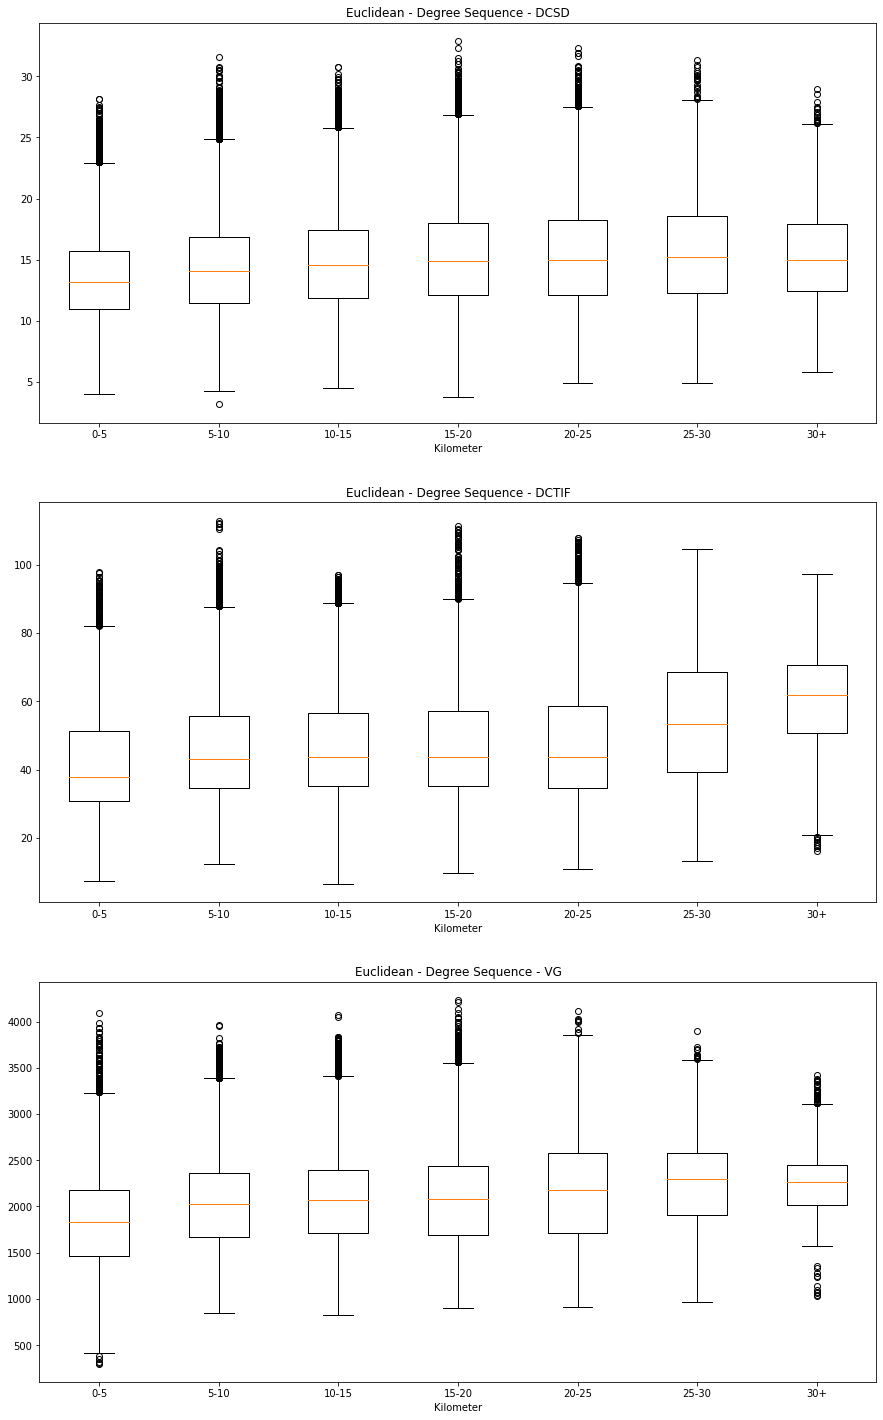

In [18]:
boxplot_seq(euclidean_dist_dcsd_degrees,euclidean_dist_dctif_degrees,euclidean_dist_vg_degrees,'Euclidean','Degree Sequence')

### Manhattan

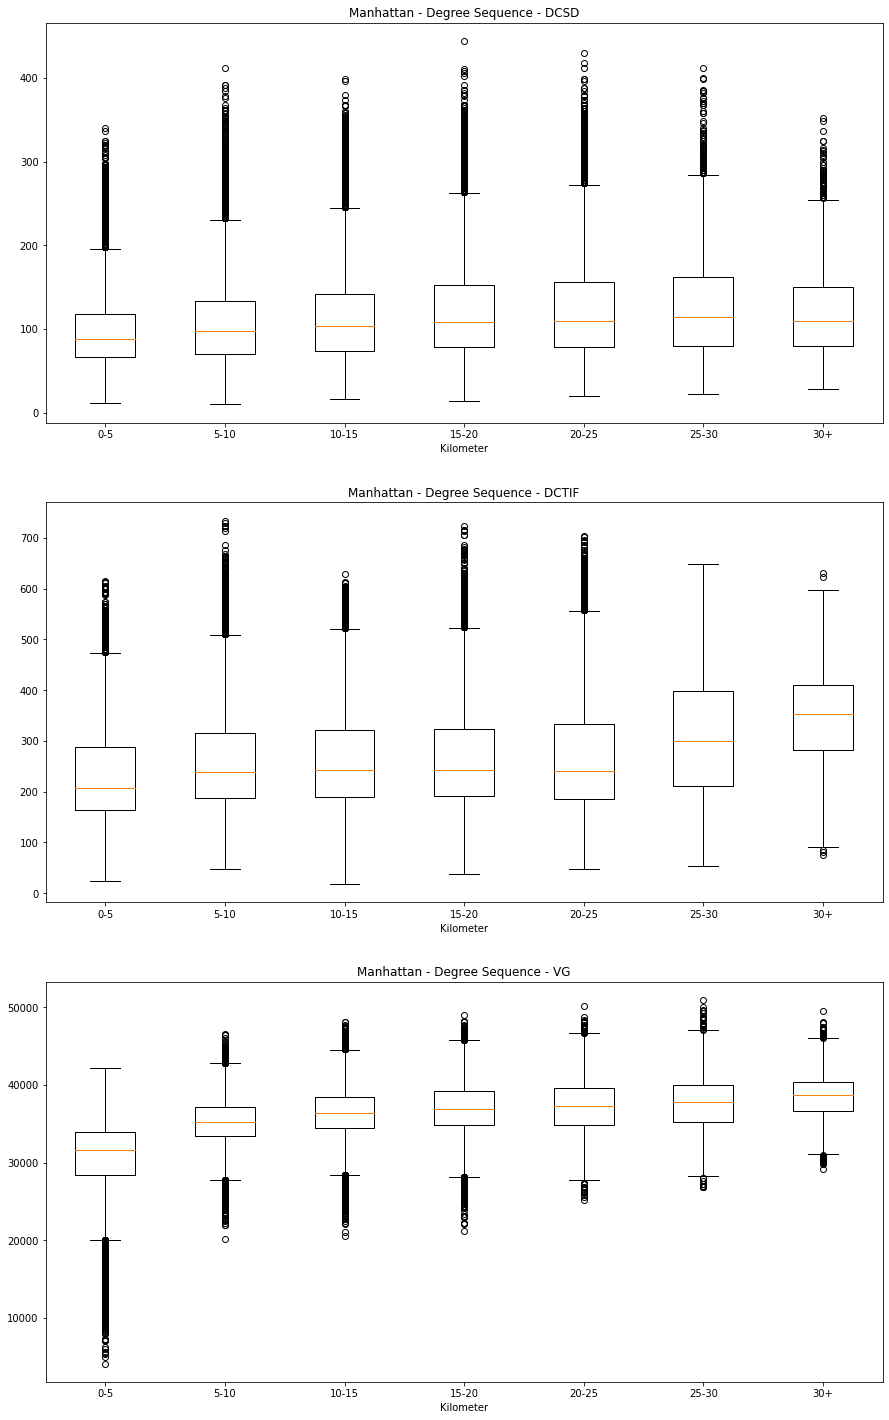

In [19]:
boxplot_seq(manhattan_dist_dcsd_degrees,manhattan_dist_dctif_degrees,manhattan_dist_vg_degrees,'Manhattan','Degree Sequence')

### Canberra

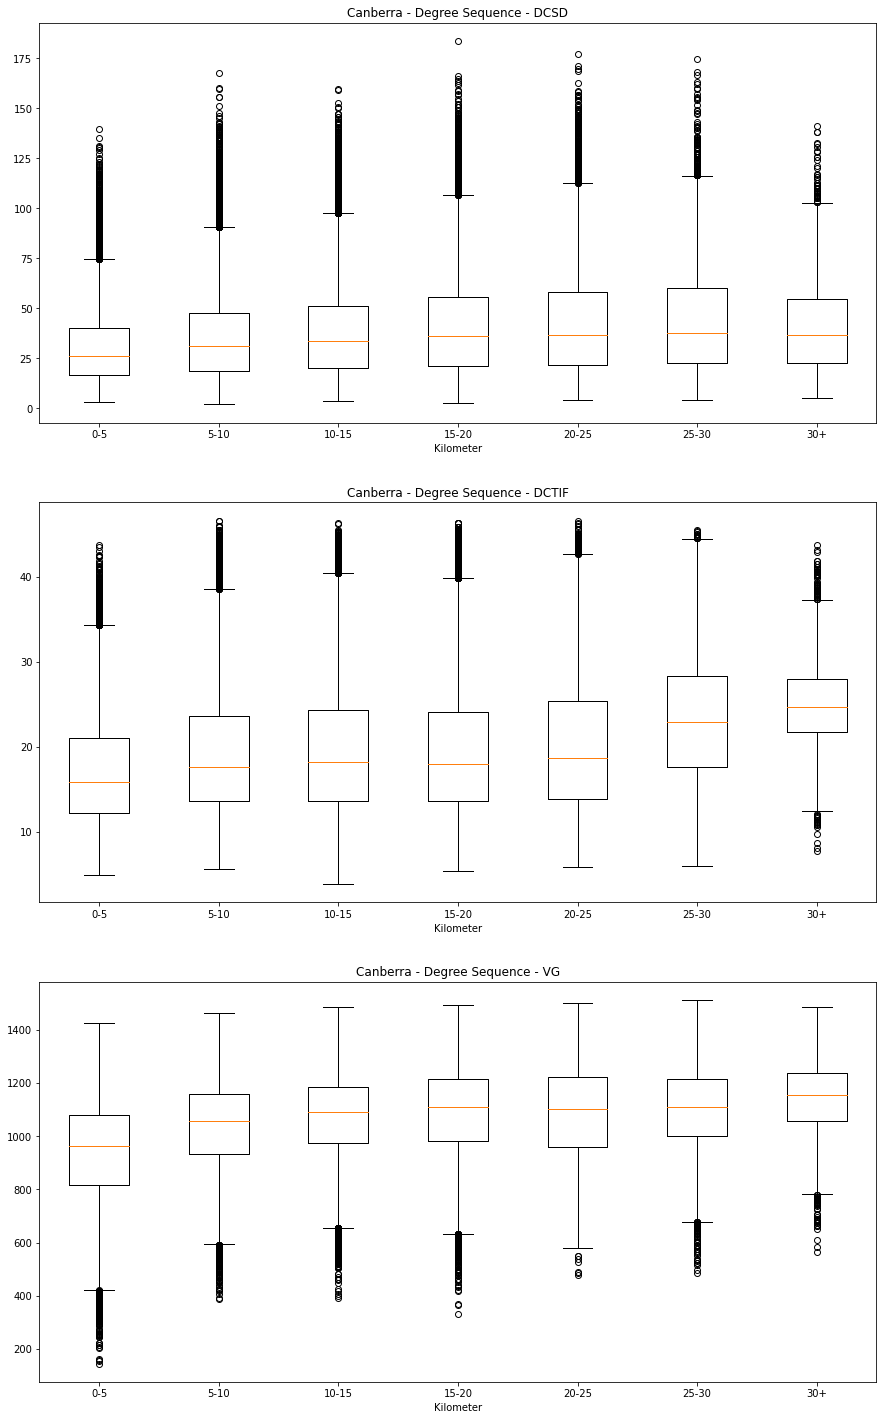

In [20]:
boxplot_seq(canberra_dist_dcsd_degrees,canberra_dist_dctif_degrees,canberra_dist_vg_degrees,'Canberra','Degree Sequence')

### Cosine

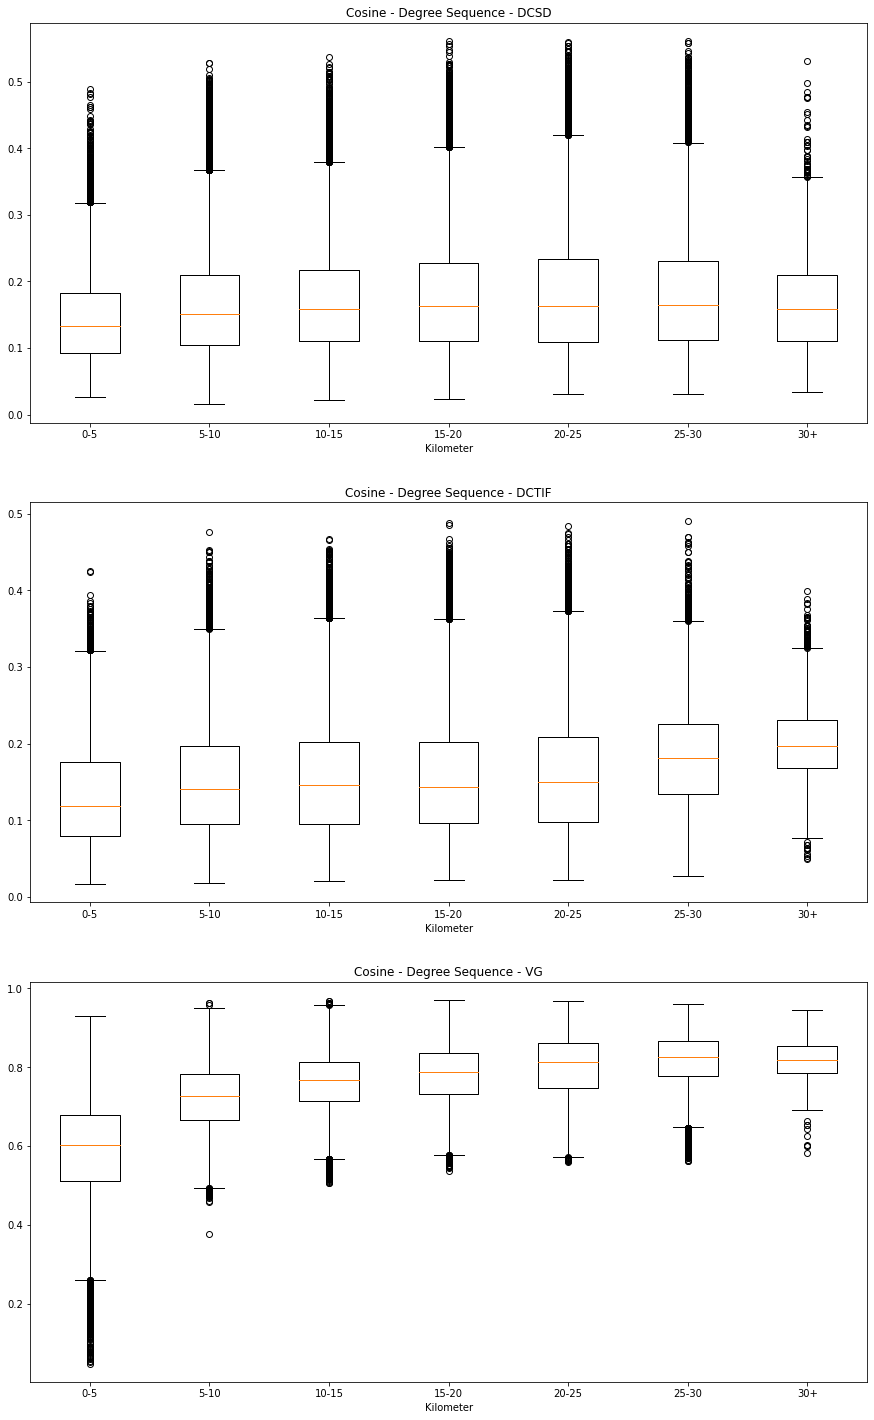

In [21]:
boxplot_seq(cosine_dist_dcsd_degrees,cosine_dist_dctif_degrees,cosine_dist_vg_degrees,'Cosine','Degree Sequence')

### Jensen-Shannon

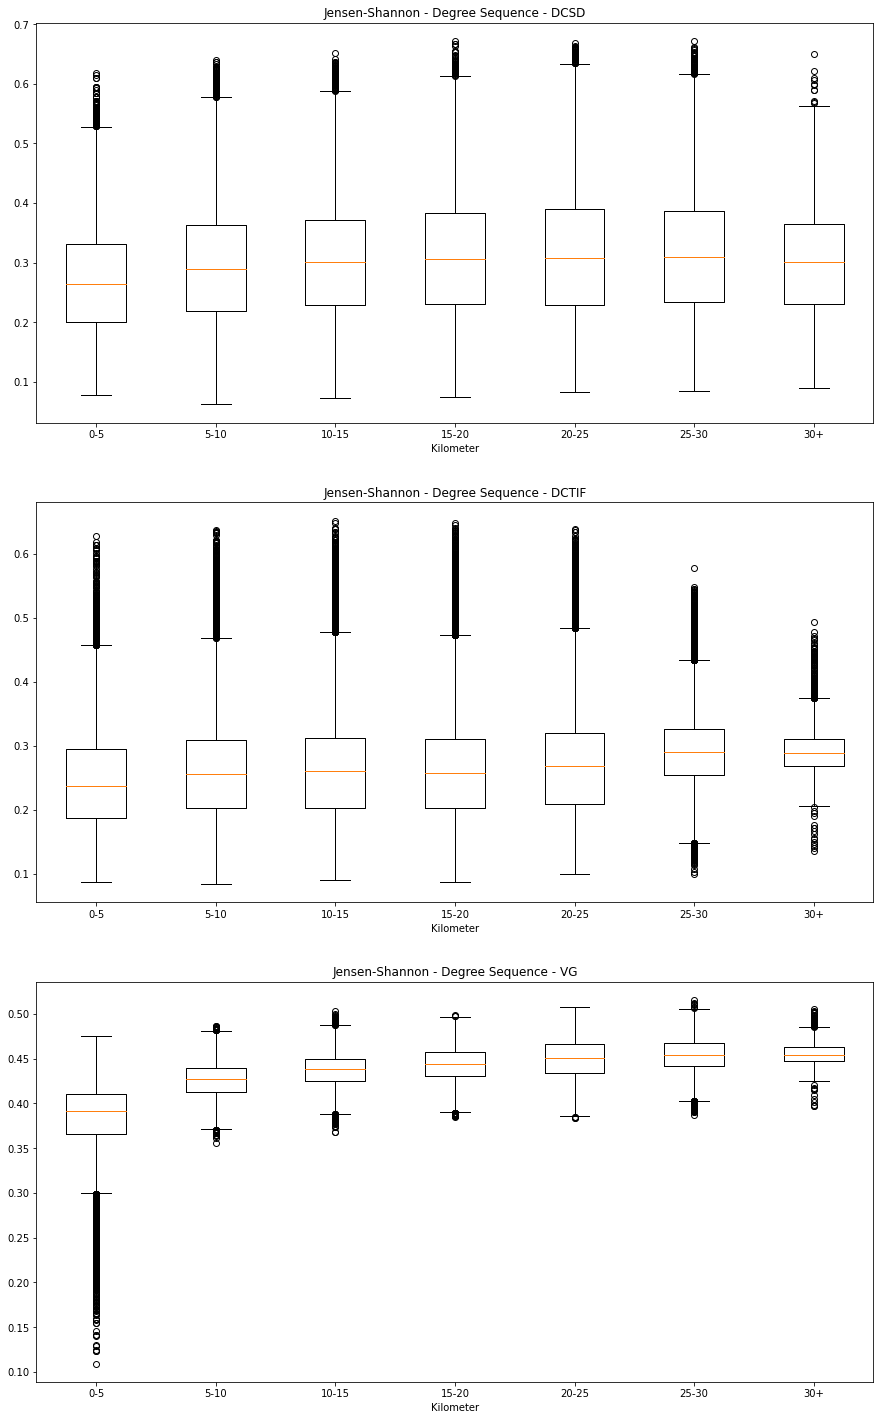

In [22]:
boxplot_seq(jensenshannon_dist_dcsd_degrees,jensenshannon_dist_dctif_degrees,jensenshannon_dist_vg_degrees,'Jensen-Shannon','Degree Sequence')

## Vetor de Closeness

### Euclidean

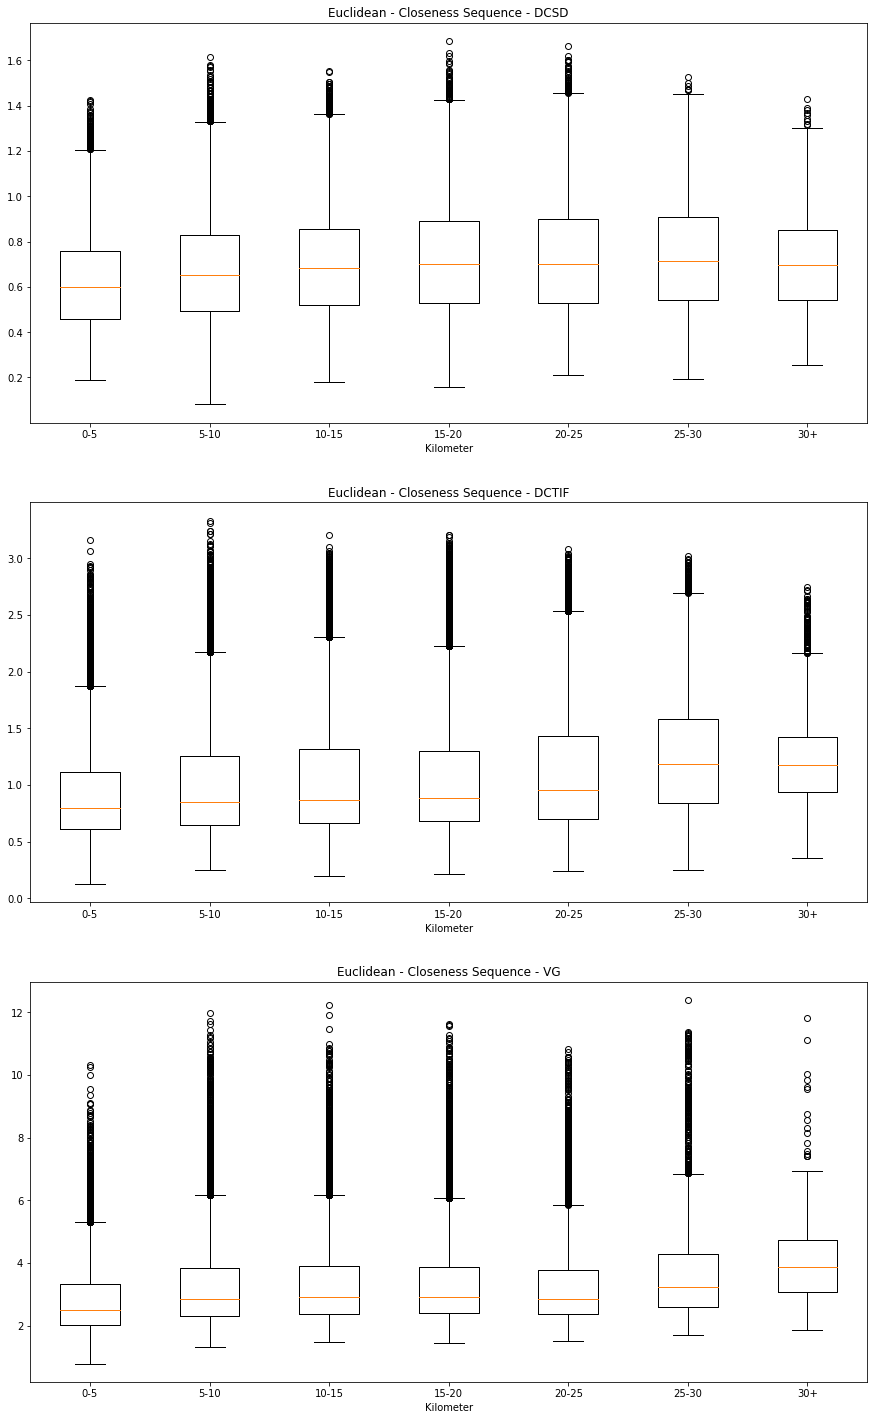

In [23]:
boxplot_seq(euclidean_dist_dcsd_closeness,euclidean_dist_dctif_closeness,euclidean_dist_vg_closeness,'Euclidean','Closeness Sequence')

### Manhattan

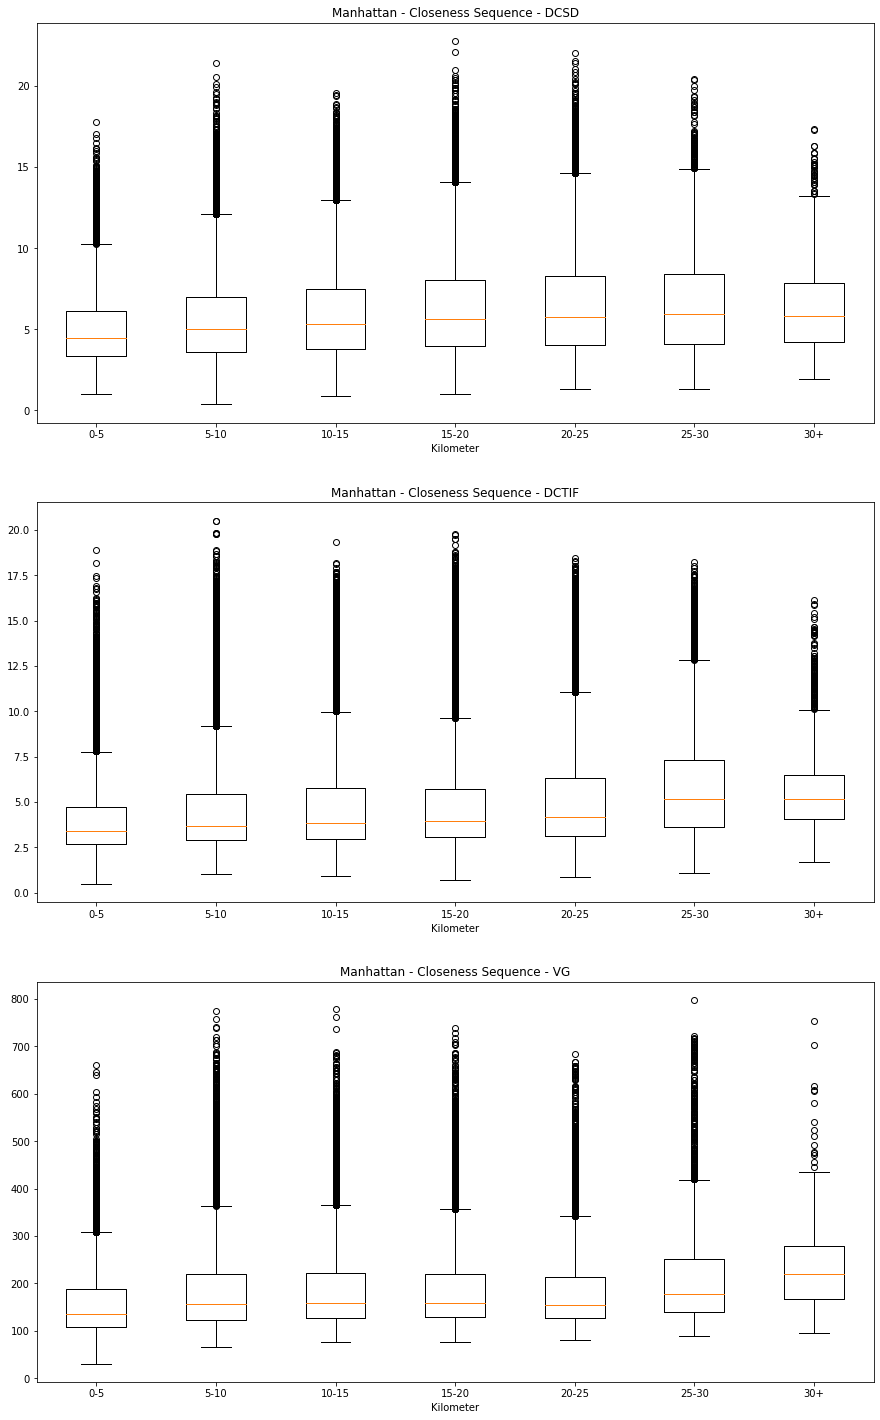

In [24]:
boxplot_seq(manhattan_dist_dcsd_closeness,manhattan_dist_dctif_closeness,manhattan_dist_vg_closeness,'Manhattan','Closeness Sequence')

### Canberra

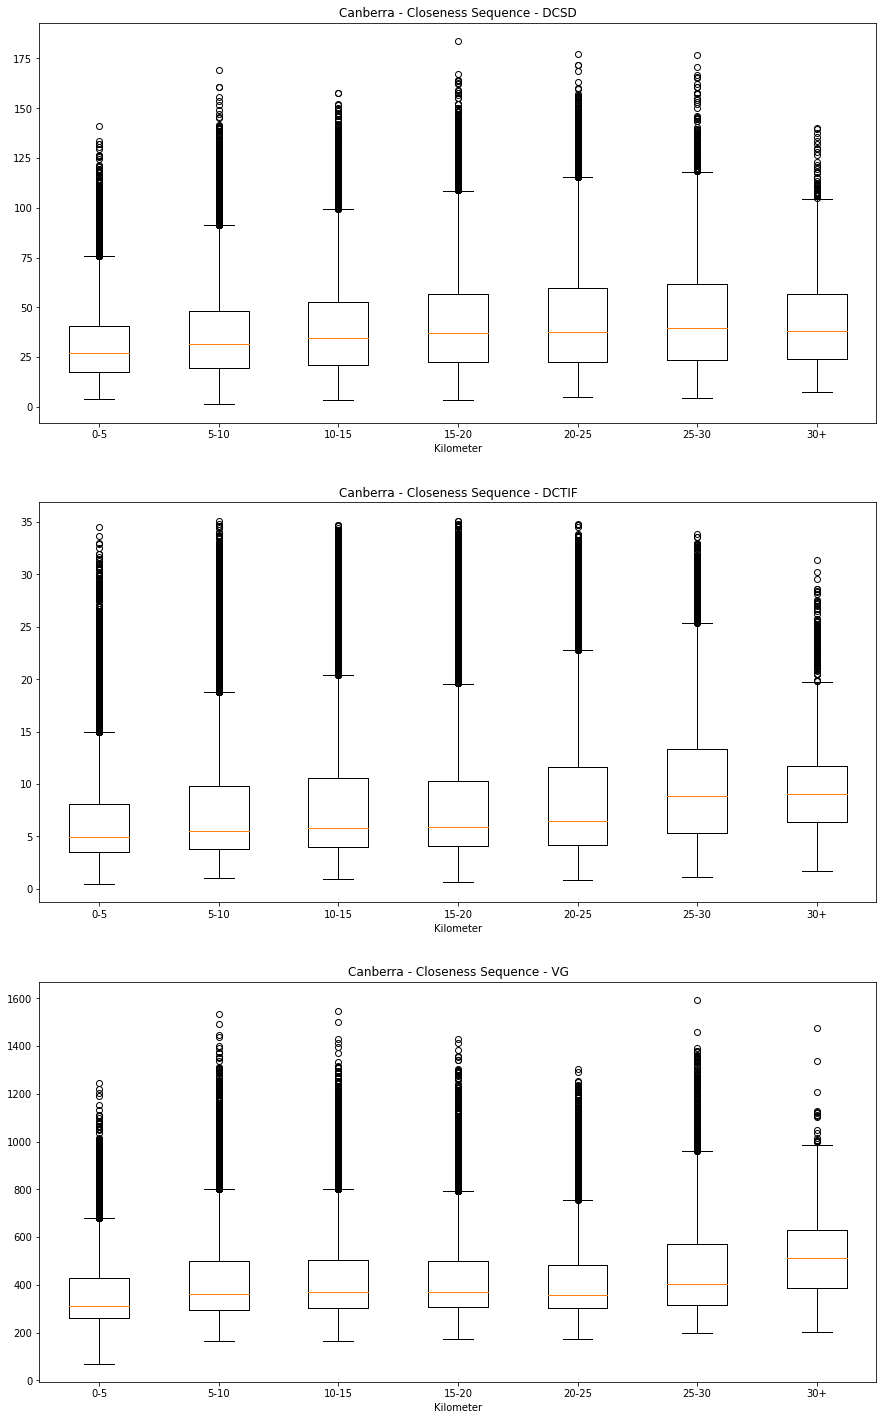

In [25]:
boxplot_seq(canberra_dist_dcsd_closeness,canberra_dist_dctif_closeness,canberra_dist_vg_closeness,'Canberra','Closeness Sequence')

### Cosine

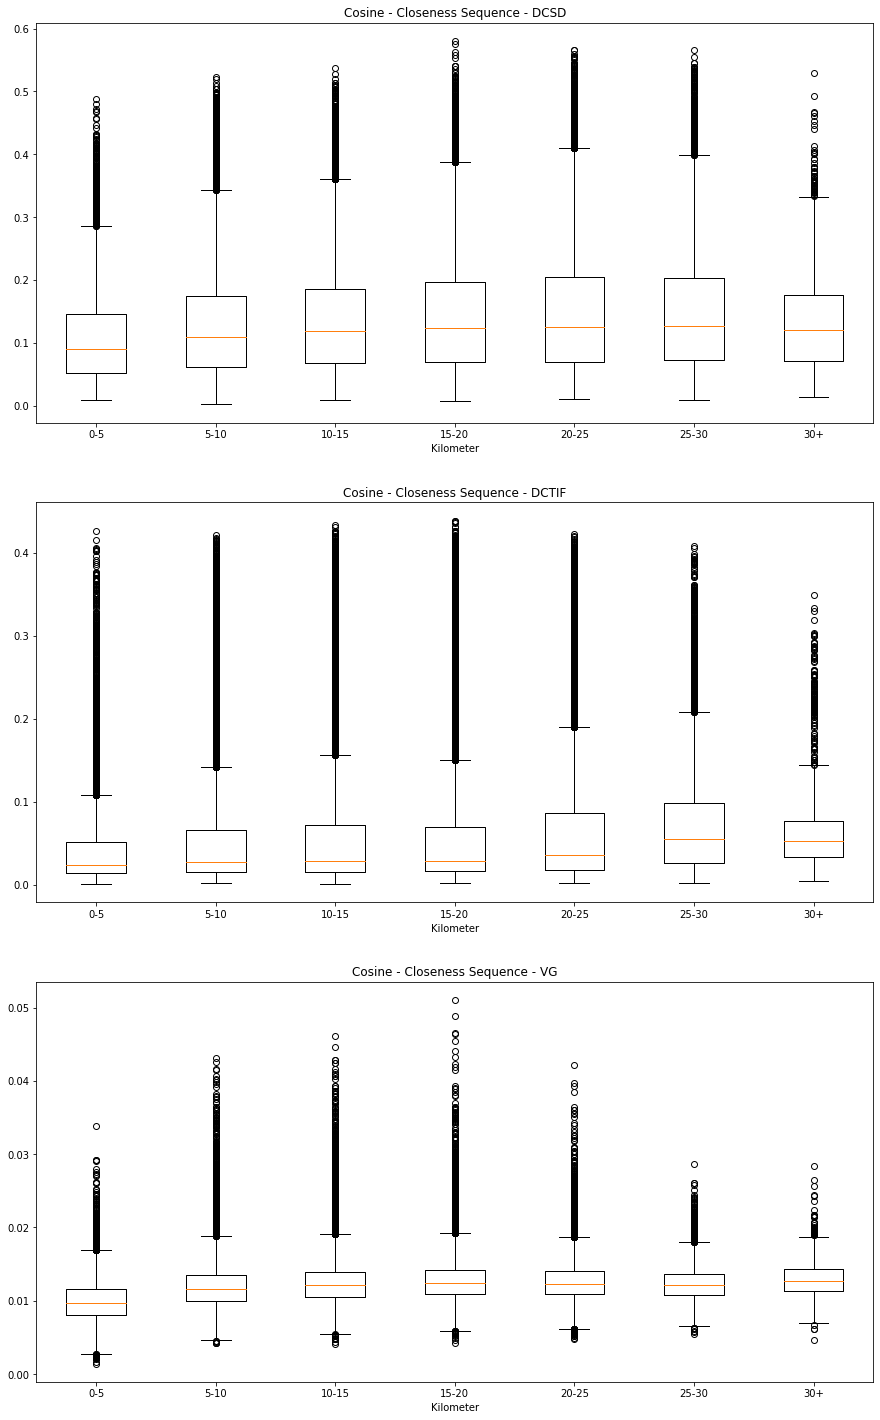

In [26]:
boxplot_seq(cosine_dist_dcsd_closeness,cosine_dist_dctif_closeness,cosine_dist_vg_closeness,'Cosine','Closeness Sequence')

### Jensen-Shannon

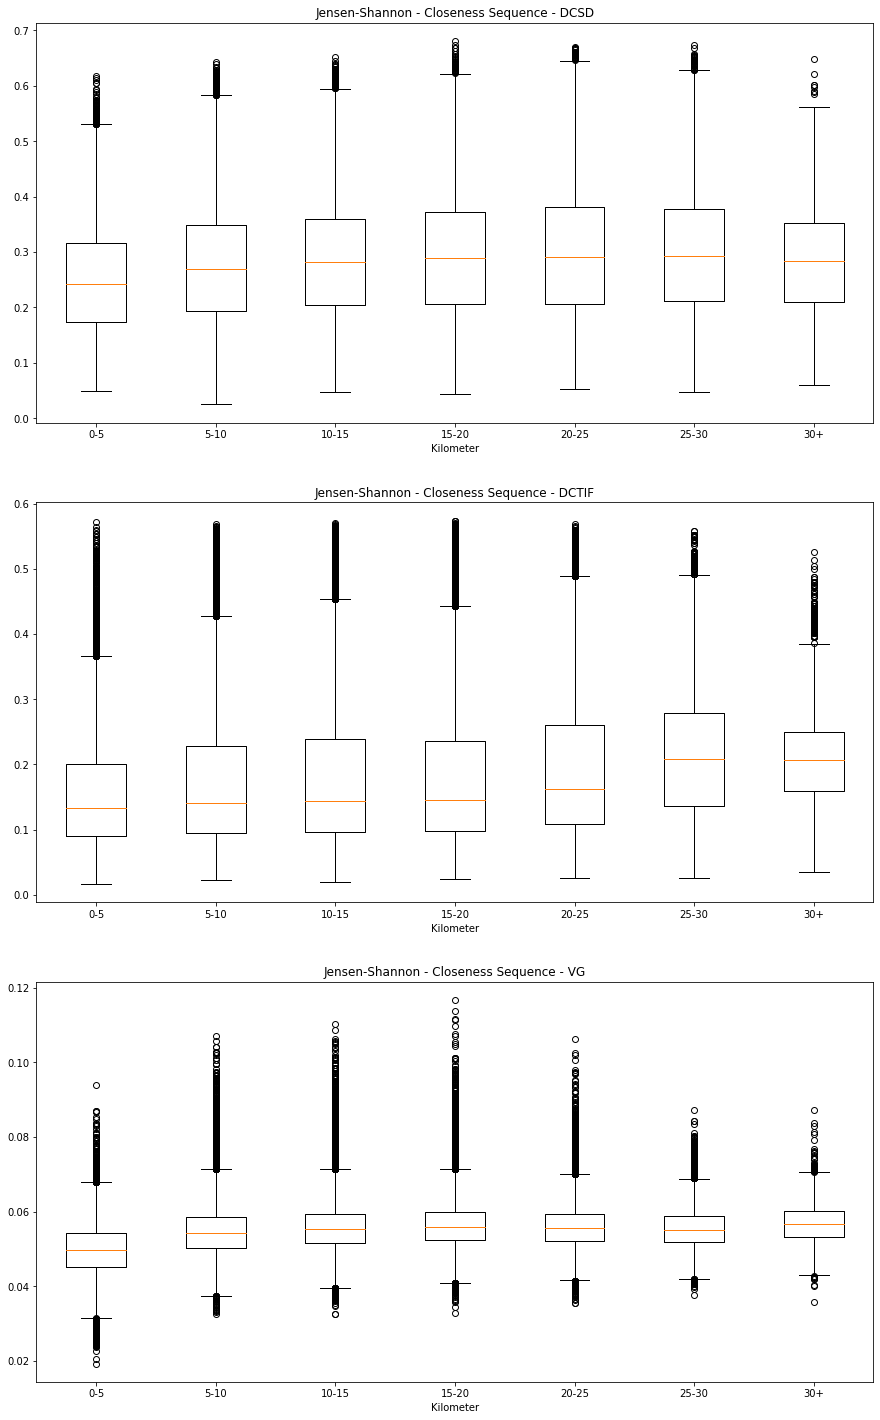

In [27]:
boxplot_seq(jensenshannon_dist_dcsd_closeness,jensenshannon_dist_dctif_closeness,jensenshannon_dist_vg_closeness,'Jensen-Shannon','Closeness Sequence')

## Vetor de Betweenness

### Euclidean

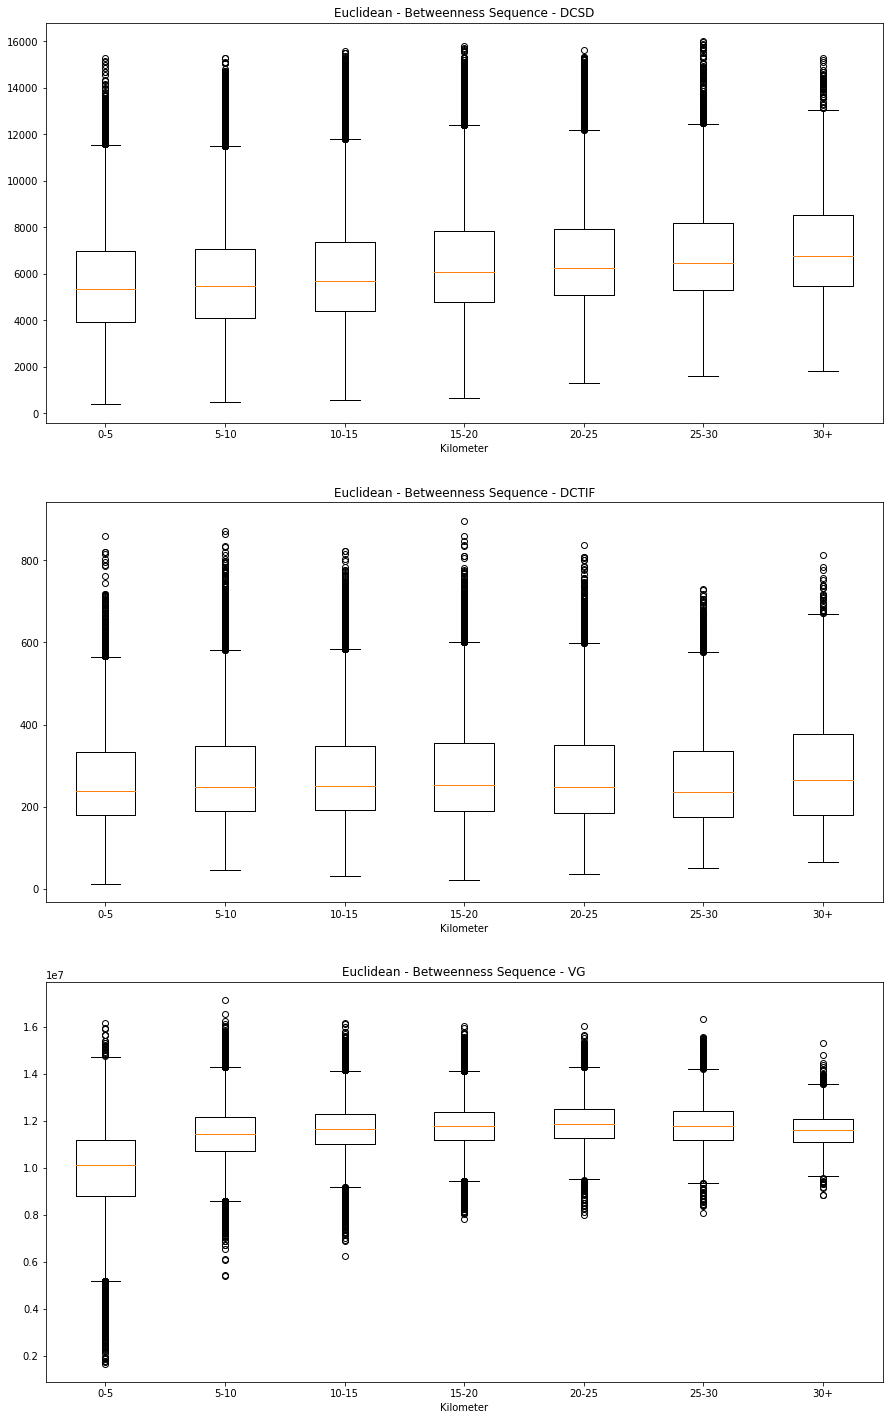

In [28]:
boxplot_seq(euclidean_dist_dcsd_betweenness,euclidean_dist_dctif_betweenness,euclidean_dist_vg_betweenness,'Euclidean','Betweenness Sequence')

### Manhattan

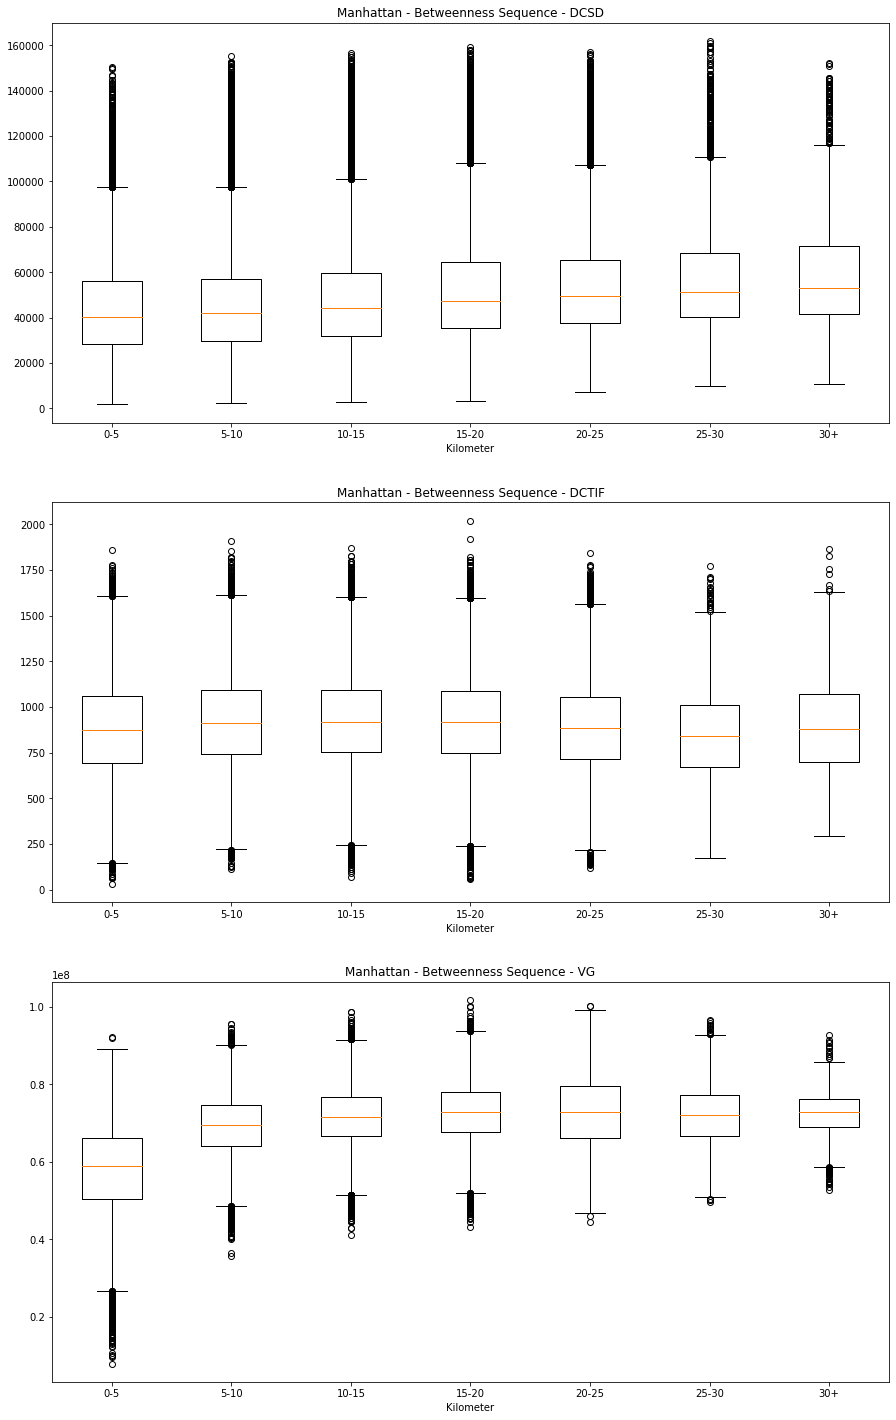

In [29]:
boxplot_seq(manhattan_dist_dcsd_betweenness,manhattan_dist_dctif_betweenness,manhattan_dist_vg_betweenness,'Manhattan','Betweenness Sequence')

### Canberra

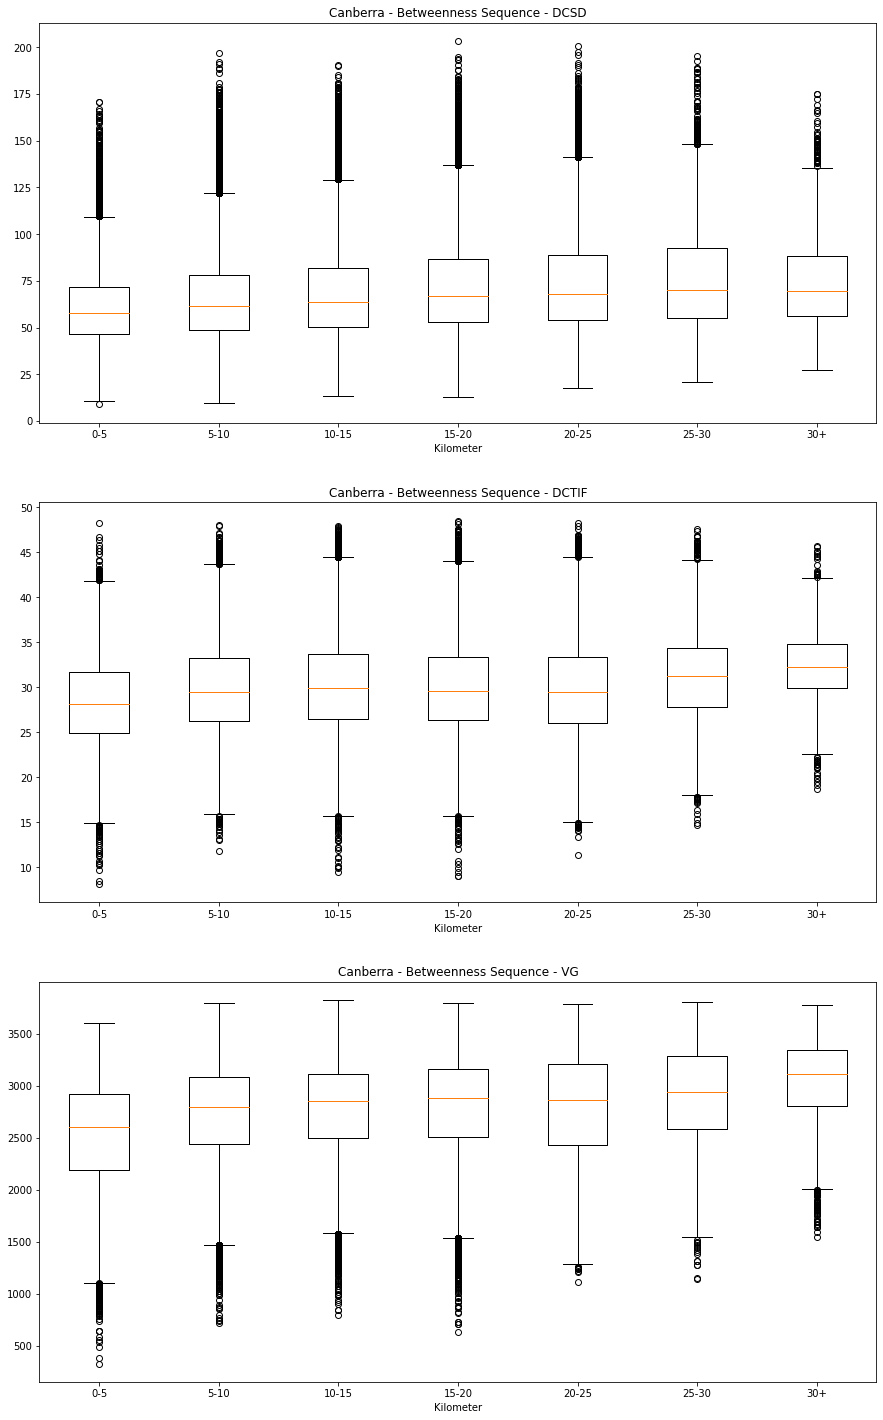

In [30]:
boxplot_seq(canberra_dist_dcsd_betweenness,canberra_dist_dctif_betweenness,canberra_dist_vg_betweenness,'Canberra','Betweenness Sequence')

### Cosine

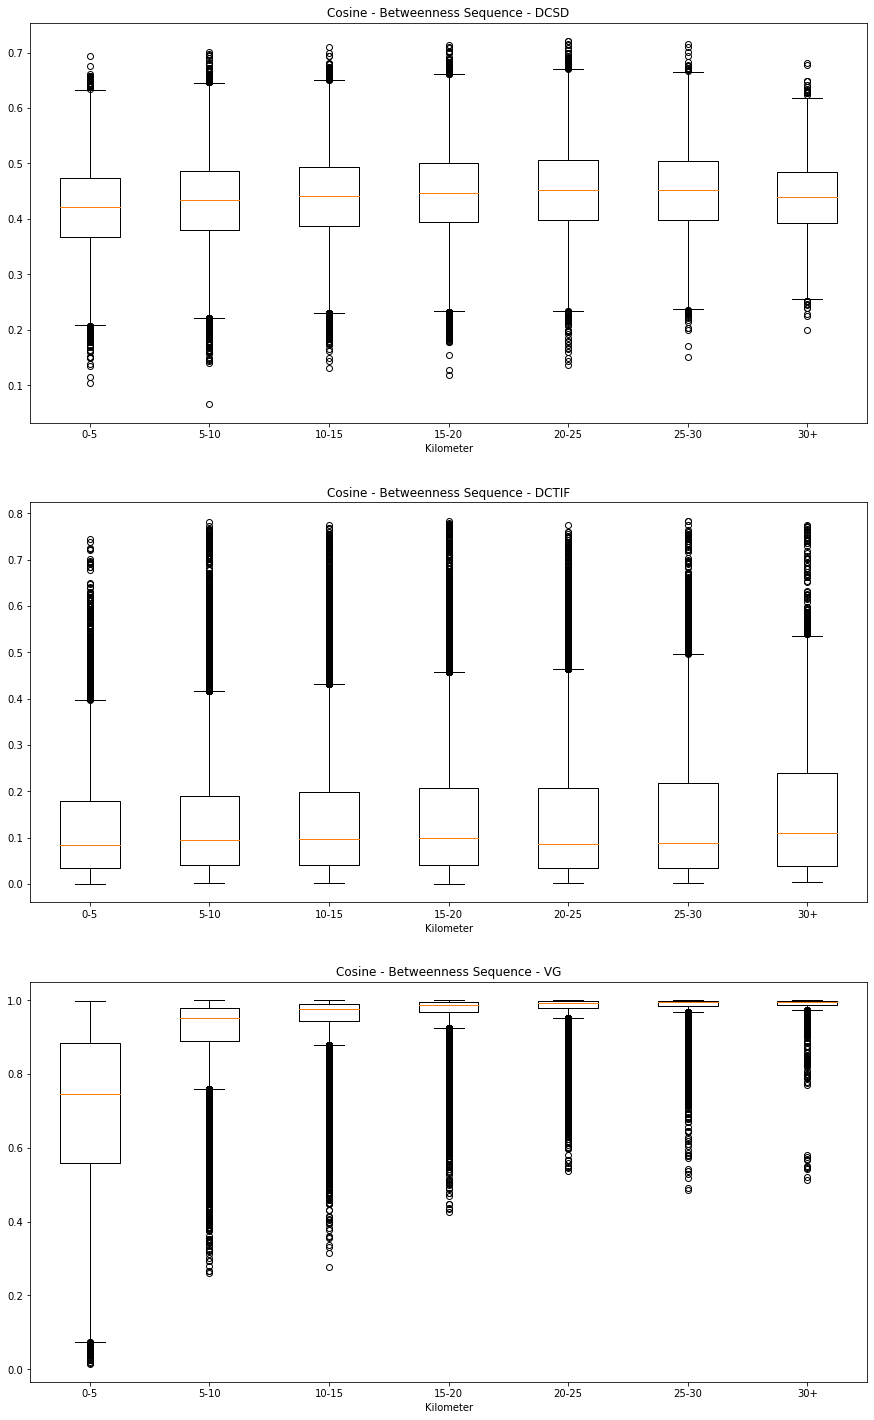

In [31]:
boxplot_seq(cosine_dist_dcsd_betweenness,cosine_dist_dctif_betweenness,cosine_dist_vg_betweenness,'Cosine','Betweenness Sequence')

### Jensen-Shannon

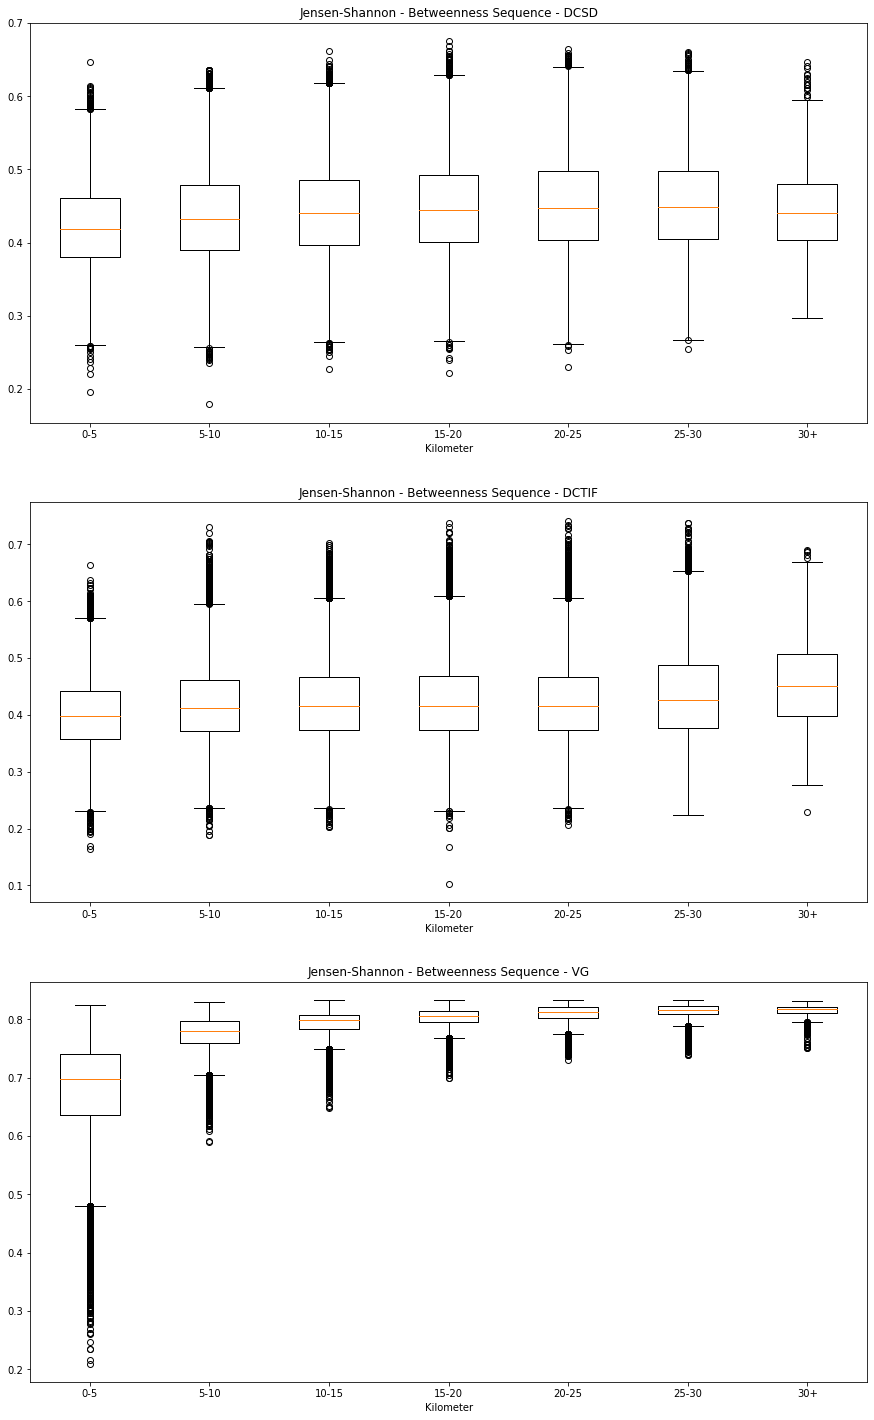

In [32]:
boxplot_seq(jensenshannon_dist_dcsd_betweenness,jensenshannon_dist_dctif_betweenness,jensenshannon_dist_vg_betweenness,'Jensen-Shannon','Betweenness Sequence')

# Reconstrução do grafo geográfico

In [12]:
def g_graph(data):
    """
    Parameters:
    -----------
        data - Dicionário contendo os pares de séries temporais e seus respectivos pesos. Cada par presente no 
        dicionário representa uma conexão entre dois nós da rede.
    Returns:
    --------
        plt - Contém o plot do grafo
        gr - Variável contendo o objeto grafo do tipo igraph 
    """
    gr = igraph.Graph();
    gr.add_vertices(587); # Valor estático. O número de nós na rede geográfica é constante.
    gr.add_edges((list(data.keys())));
    gr.vs['x'] = [position[i][1] for i in range(587)];
    gr.vs['y'] = [position[j][0] for j in range(587)];
    gr.es['weight'] = [i[1] for i in list(data.values())];
    lyt = [];
    for i in range(587):
        lyt.append( (gr.vs[i]['x'],gr.vs[i]['y']) );
    visual_style = {};
    visual_style['layout'] = lyt;
    visual_style['bbox'] = (500,500);
    visual_style['margin'] = 20;
    visual_style['vertex_size'] = 5;
    visual_style['edge_width'] = 1.5;
    plt = igraph.plot(gr,**visual_style);
    #igraph.plot(gr,'basin-region-js-0dot358.png',**visual_style);
    return(plt,gr); #plot object and the graph itself

In [13]:
# Dictionary containing the topological distance between two points
# unweighted shortest path - BFS algorithm
# weighted shortest path - Djikstra algorithm
def shortest_paths(g):
    """
    Parameters:
    -----------
        Graph object (igraph)
    Returns:
    --------
        The shortest path between all connected nodes
    """
    s_paths = {};
    ctrl = 1;
    for i in range(g.vcount()):
        for j in range(ctrl,g.vcount()):
            path = g.shortest_paths(source=g.vs[i],target=g.vs[j])#,weights=g.es['weight']) 
            if (path[0][0] != float('inf')):
                s_paths[i,j] = path[0][0];
        ctrl+=1
        
    return(s_paths);

In [14]:
def plot_geo_top(data):
    """
    Parameters:
    -----------
        data - Dicionário contendo os pares de séries temporais e seus respectivos pesos. Cada par presente no 
        dicionário representa uma conexão entre dois nós da rede.
        
        Retorna um gráfico contendo a distância geográfica no eixo das abscissas e distância topológica no eixo das
        ordenadas, bem como as informações do modelo de regressão linear usado para mostrar a relação entre os eixos.
    """
    geo = np.array([i[1] for i in list(data.values())]);
    top = np.array([i[0] for i in list(data.values())]);
    geo = geo.reshape(-1,1);
    top = top.reshape(-1,1);
    # Linear Regression
    reg = LinearRegression();
    reg.fit(geo,top);
    score = round(reg.score(geo,top),4);
    a = round(reg.coef_[0][0],4);
    b = reg.intercept_;
    top_new = (a*geo) + b;
    # Plot
    plt.figure(figsize=(15,10));
    plt.scatter(geo,top,s=20);
    plt.plot(geo,top_new,color='red');
    plt.grid(True);
    plt.xlabel('Geographical Distance [km]');
    plt.ylabel('Topological Distance [Number of edges]');
    plt.text((max(geo)*0.5)[0], (min(top))[0], 'R² = '+str(score), horizontalalignment='center',verticalalignment='center',fontsize='xx-large');
    plt.text((max(geo)*0.75)[0], (min(top))[0], 'Slope = '+str(a), horizontalalignment='center',verticalalignment='center',fontsize='xx-large');

## Estabelecendo links usando Mutual Information

In [141]:
def mutual_information(ts,thrshld):
    """
    Parameters:
    -----------
        ts - Conjunto de séries temporais lidas inicialmente. Cada série é comparada com todas as outras usando 
        mutual information. 
        thrshld - É o valor de limiar que limita quais séries serão conectadas. Para o caso do mutual information, 
        as séries serão conectadas se o valor obtido na comparação for maior que o threshold.
    Returns:
    --------
        mi_dict - Retorna um dicionário contendo os pares de séries cujo valor de mutual information foi superior
        ao limiar determinado. As chaves correspondem às séries e os valores são a distância geográfica entre essas
        séries e o valor de peso que será usado para construir o grafo geográfico.
    """    
    mi_dict = {};
    ctrl = 1;
    for i in range(len(ts)):
        for j in range(ctrl,len(ts)):
            mi = sk.normalized_mutual_info_score(ts[i], ts[j], average_method='arithmetic');
            if (mi >= thrshld):
                mi_dict[i,j] = [geo_dist[i,j],(1/mi)];
        ctrl += 1;
    return(mi_dict);

In [142]:
# Execution time: 323s
i = time.time();
mutual_inf = mutual_information(meteorological_time_series,thrshld=0.61);
e = time.time();
print(e-i);

345.95439314842224


In [150]:
mi_km = [i[0] for i in list(mutual_inf.values())];

In [151]:
max(mi_km)

3.1622776601683795

In [152]:
g_graph_mi = g_graph(mutual_inf);

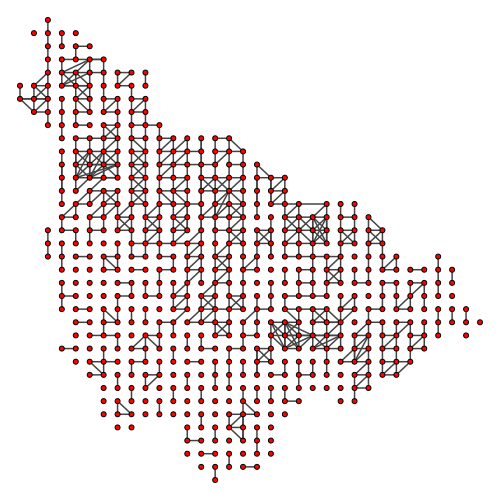

In [153]:
# Graph plot - Mutual Information
g_graph_mi[0]

In [154]:
# Shortest paths - Mutual Information 
s_paths_mi = shortest_paths(g_graph_mi[1]);

In [155]:
# Shortest paths and Geographical distance - Mutual Information
topological_geographical_dist_mi = {}; # First: Topological distance; Second: Geographical distance
for i in s_paths_mi:
    topological_geographical_dist_mi[i] = [s_paths_mi[i],geo_dist[i]];

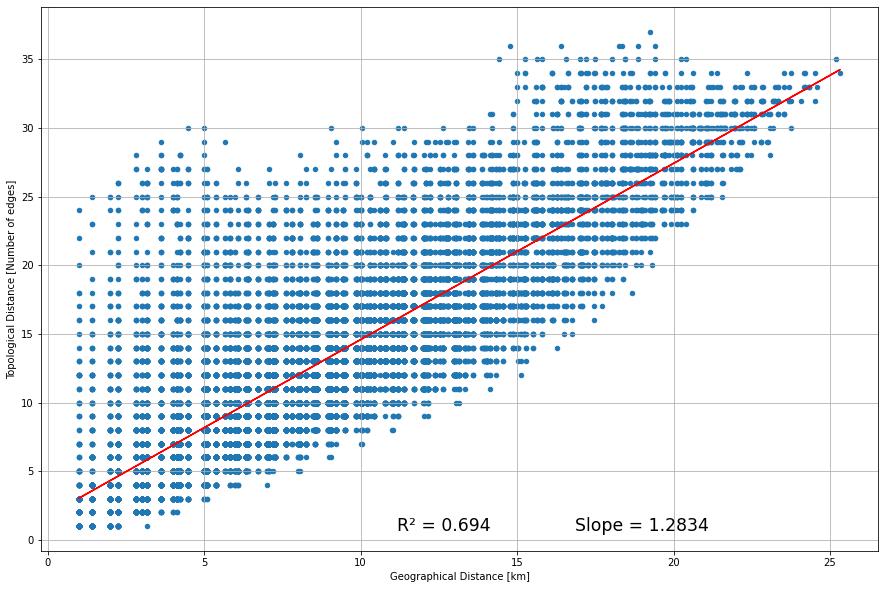

In [156]:
# Geographical Distance x Topological Distance
plot_geo_top(topological_geographical_dist_mi)

## Estabelecendo links usando Pearson Correlation

In [15]:
def pearson_correlation(ts,thrshld):
    """
    Parameters:
    -----------
        ts - Conjunto de séries temporais lidas inicialmente. Cada série é comparada com todas as outras usando 
        mutual information. 
        thrshld - É o valor de limiar que limita quais séries serão conectadas. Para o caso da correlação de 
        Pearson, as séries serão conectadas se o valor obtido na comparação for maior que o threshold.
    Returns:
    --------
        mi_dict - Retorna um dicionário contendo os pares de séries cujo coeficiente de correlação de Pearson
        foi superior ao limiar determinado. As chaves correspondem às séries e os valores são a distância 
        geográfica entre essas séries e o valor de peso que será usado para construir o grafo geográfico.
    """
    ctrl = 1; # Used to avoid comparisons between equal and simetric series
    pc_dict = {};
    for i in range(len(ts)):
        for j in range(ctrl,len(ts)):
            corr = scipy.stats.pearsonr(ts[i],ts[j])[0]
            if (corr >= thrshld):
                pc_dict[i,j] = [geo_dist[i,j], (1/corr)];
        ctrl += 1;
    return(pc_dict);

In [16]:
# Execution time: 14s
i = time.time();
pearson = pearson_correlation(meteorological_time_series,thrshld=0.86);
e = time.time();
print(e-i);

13.677790403366089


In [17]:
p = [i[0] for i in list(pearson.values())]

In [18]:
# Comprimento, em km, da maior conexão usando Pearson Correlation
max(p)

3.1622776601683795

In [161]:
g_graph_pc = g_graph(pearson);

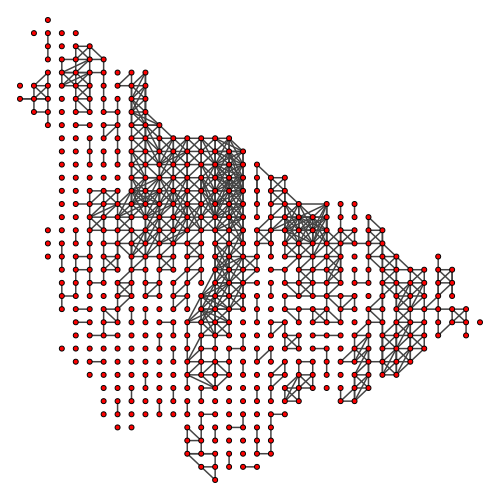

In [162]:
# Graph plot - Pearson Correlation
g_graph_pc[0]

In [163]:
# Shortest paths - Pearson Correlation 
s_paths_pc = shortest_paths(g_graph_pc[1]);

In [164]:
# Shortest paths and Geographical distance - Pearson Correlation
topological_geographical_dist_pc = {}; # First: Topological distance; Second: Geographical distance
for i in s_paths_pc:
    topological_geographical_dist_pc[i] = [s_paths_pc[i],geo_dist[i]];

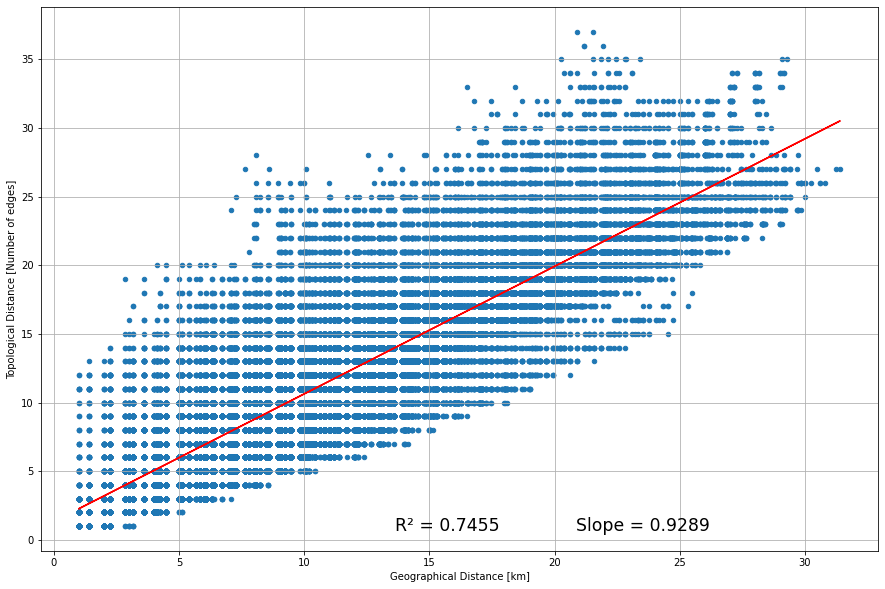

In [165]:
# Geographical Distance x Topological Distance
plot_geo_top(topological_geographical_dist_pc)

## Estabelecendo links usando distância Jensen-Shanon entre a distribuição de graus da rede

In [166]:
# The jensen-shannon distance was calculated already
js_dist_degree_thrshld = {};
thrshld = 0.3245;
for i in jensenshannon_dist_vg_degrees:
    if jensenshannon_dist_vg_degrees[i] <= thrshld:
        js_dist_degree_thrshld[i] = [geo_dist[i],jensenshannon_dist_vg_degrees[i]];

In [167]:
js = [i[0] for i in list(js_dist_degree_thrshld.values())]

In [168]:
# Comprimento, em km, da maior conexão usando Jensen-Shannon Distance
max(js)

3.1622776601683795

In [169]:
g_graph_js = g_graph(js_dist_degree_thrshld);

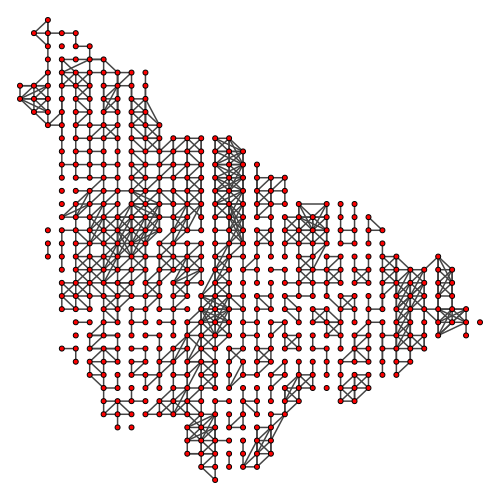

In [170]:
#  Graph plot - Jensen-Shannon Distance
g_graph_js[0]

In [171]:
# Shortest paths - Jensen-Shannon Distance
s_paths_js = shortest_paths(g_graph_js[1]);

In [172]:
# Shortest paths and Geographical distances - Jensen-Shannon Distance
topological_geographical_dist_js = {}; # First: Topological distance; Second: Geographical distance
for i in s_paths_js:
    topological_geographical_dist_js[i] = [s_paths_js[i],geo_dist[i]];

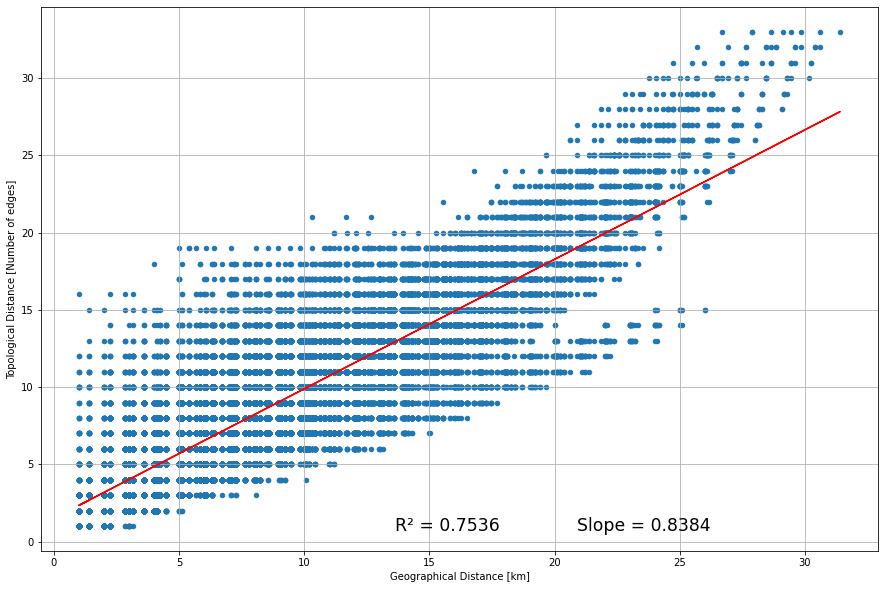

In [173]:
# Geographical Distance x Topological Distance
plot_geo_top(topological_geographical_dist_js)